# Sample Functions for Analysis

In [1]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import nltk
from nltk.collocations import *

import networkx as nx
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Load Data

In [2]:
data = pd.read_pickle("data/coca_data_normalized.pkl")

In [3]:
#data = data[data['genre']!='twitter']
data.genre.unique()

array(['MAG', 'SPOK', 'NEWS'], dtype=object)

## Additional Cleaning

In [4]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)

In [5]:
stopwords = freq.index[:38]
# stop at child

In [6]:
freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in data['normalized_words_POS'].sum())

In [7]:
topverbs = freqdist_POStoWord['VB'].most_common(50) # stop at protect
stopwords_verbs = [v for v,count in topverbs] 

In [8]:
others=['qwq', 'voiceover','>','+', 'end', 'video', 'clip', 'morning', 'tonight']
stopwords_all=list(stopwords)+stopwords_verbs+others
stopwords_all.remove('american') # might be useful for w2v

In [9]:
len(stopwords_all)

96

In [10]:
stopwords_all

['say',
 'people',
 'think',
 'go',
 'year',
 'know',
 'mr',
 'time',
 'come',
 'like',
 'state',
 'new',
 'president',
 'right',
 'want',
 'war',
 'country',
 'work',
 'day',
 'have',
 'government',
 'world',
 'way',
 'get',
 'thing',
 'look',
 'unite',
 'man',
 'u.s',
 'take',
 'live',
 'talk',
 'be',
 'today',
 'tell',
 'force',
 'try',
 'be',
 'have',
 'do',
 'get',
 'go',
 'make',
 'see',
 'take',
 'say',
 'think',
 'let',
 'know',
 'come',
 'help',
 'give',
 'tell',
 'want',
 'find',
 'look',
 'work',
 'keep',
 'talk',
 'try',
 'begin',
 'bring',
 'put',
 'stop',
 'like',
 'ask',
 'leave',
 'happen',
 'use',
 'stay',
 'believe',
 'move',
 'continue',
 'pay',
 'become',
 'live',
 'understand',
 'start',
 'change',
 'provide',
 'feel',
 'hear',
 'call',
 'meet',
 'mean',
 'show',
 'run',
 'qwq',
 'voiceover',
 '>',
 '+',
 'end',
 'video',
 'clip',
 'morning',
 'tonight']

In [11]:
def more_stopwords(word_list, stopwords):
    normalized = []
    for w in word_list:
        if w not in stopwords:
            normalized.append(w)
    return normalized

data['normalized_words'] = data['normalized_words'].apply(lambda x: more_stopwords(x, stopwords_all))

In [12]:
# TFIDF vectoriser - Clustering and Topic Models
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])

In [13]:
data_vectoriser.vocabulary_.keys()

dict_keys(['radio', 'fled', 'suarez', 'success', 'story', 'focus', 'miles', 'west', 'early', 'evening', 'television', '30', 'seven', 'months', 'mother', 'taking', 'cuba', 'policy', 'freedom', '18', 'hours', 'begin', 'millions', 'immigrants', 'america', 'social', 'economic', '50', 'named', '25', 'night', 'low', 'water', 'released', 'money', 'party', 'illegal', 'cuban', 'single', 'began', 'ended', 'act', 'camp', 'ii', 'key', 'friday', 'term', 'means', 'forward', 'late', 'sunday', '40', '13', 'director', 'operations', 'language', 'station', 'greater', 'population', 'second', 'largest', 'makes', 'film', 'looked', 'september', 'wife', 'built', 'jobs', 'tv', 'middle', 'class', 'neighborhood', 'yes', 'white', 'cost', 'rate', 'independent', 'daughter', 'school', 'education', 'college', 'choice', 'financial', 'security', 'bring', 'making', 'spending', 'control', 'nearly', 'remains', 'look', 'needs', 'english', 'step', 'protect', 'future', 'allowed', 'leave', 'wanted', 'best', 'let', 'immigratio

In [14]:
# Topic Models
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [177]:
# W2V
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [more_stopwords(lucem_illud_2020.normalizeTokens(s), stopwords_all) for s in x])

In [16]:
data.head()

,text_id,text,word_count,year,genre,source,title,publication_info,tokenized_words,normalized_words,normalized_words_POS,tokenized_sents,normalized_sents,reduced_tokens
0,2018849,""" bums . "" that 's what radio havana called ...",2950,1990,MAG,Money,This is the land of opportunity.,"Vol. 19 Issue 8, p98, 8p, 1 chart, 3c, 4bw\r\n","[bums, that, 's, what, radio, havana, called, ...","[bum, radio, havana, cubans, flee, ago, thug, ...","[( , _SP), ("", ``), (bums, NNS), (., .), ("", ...","[[bums], [that, 's, what, radio, havana, calle...","[[bum], [radio, havana], [cubans, flee, ago, t...","[radio, suarez, success, story, focus, west, e..."
1,2018850,section : investing expanding petrochemical ...,2514,1990,MAG,Money,Betting on regional booms.,"Vol. 19 Issue 8, p110, 5p, 1 chart, 2c\r\n","[section, investing, expanding, petrochemical,...","[section, invest, expand, petrochemical, plant...","[( , _SP), (section, NN), (:, :), (investing, ...","[[section, investing, expanding, petrochemical...","[[section, invest, expand, petrochemical, plan...","[business, operation, region, money, young, bu..."
2,2019006,section : clothes that work american history ...,1667,1990,MAG,MotherEarth,The evolution of jeans.,"p60, 4p, 5c, 2bw\r\n","[section, clothes, that, work, american, histo...","[section, clothe, american, history, samoans, ...","[( , _SP), (section, NN), (:, :), (clothes, NN...","[[section], [clothes, that, work, american, hi...","[[section], [clothe, american, history, samoan...","[history, west, hand, chance, heavy, age, san,..."
3,2019061,section : movements from socialist to republi...,1754,1990,MAG,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n","[section, movements, from, socialist, to, repu...","[section, movement, socialist, republicans, ge...","[( , _SP), (section, NN), (:, :), (movements, ...","[[section], [movements, from, socialist, to, r...","[[section], [movement, socialist, republicans,...","[movement, republicans, student, university, s..."
4,2019063,inside a dusty cement-block house with worn ...,6032,1990,MAG,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n","[inside, a, dusty, cement, block, house, with,...","[inside, dusty, cement, block, house, wear, li...","[( , _SP), (inside, IN), (a, DT), (dusty, JJ)...","[[inside, a, dusty, cement, block, house, with...","[[inside, dusty, cement, block, house, wear, l...","[inside, conference, table, face, press, white..."


## Freq and Word Counts

In [17]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)

In [18]:
freq[:20]

,count
american,11959
child,10890
refugee,10838
good,10611
need,10577
house,10265
family,9936
long,9892
$,9772
woman,9519


In [19]:
years = data['year'].unique()
years

array([1990, 1991, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       1996, 2013, 2014, 2015])

In [20]:
# get context

for yr in years:
    yearly = data[data['year']==yr]
    post_text = nltk.Text(yearly['tokenized_words'].sum())
    index = nltk.text.ConcordanceIndex(post_text) 
    print(yr)
    index.print_concordance('refugee', lines=10) # usually used as adj
    index.print_concordance('refugees', lines=10) # usually used as noun
    post_text.common_contexts(['refugees'])

1990
Displaying 10 of 133 matches:
university and himself a 1960 cuban refugee mariels were driven less by politic
he wall photo black white below the refugee center where the suarezes and other
toon at second glance i look like a refugee farmer but careful examination reve
s guerrillas as we pass a family of refugee indians from the highlands dressed 
ople creating a massive and complex refugee problem half a million saudis egypt
tuation is of particular concern to refugee organizations if baghdad succeeds i
 an unusual briefing on the kuwaiti refugee dilemma and the palestinian aspect 
no one knows how many soviet jewish refugee immigrants will finally come in par
at they had better shut down contra refugee camps before michael dukakis became
d cutting why not the fanjuls are a refugee family he says the economy of the c
Displaying 10 of 350 matches:
w in the water jammed with 80 or so refugees some of them just released from cub
torm a documentary about the mariel refugees fate as h

these_from fellow_build other_in reopened_have rwandan_primarily
populations_migrant help_1he rwandan_fought chinese_from
palestinian_and destitute_immediately and_from on_cbs on_havana
resulting_are palestine_unrwa registered_rooted with_and of_crowded
economic_from
1995
Displaying 10 of 84 matches:
d years of school while detained in refugee camps abroad do amazingly well in o
 me of a photograph i had seen of a refugee child in the ruins of a bombed vill
 was continuing bush 's restrictive refugee policy and maintaining economic san
tion as an oblate arose from my own refugee experience as an exiled child livin
ungarian uprising and images of his refugee childhood is set in a virtual archi
d on battlefields in prisons and in refugee camps in other words in places of h
 of cambodians returning from their refugee camps in thailand have n't been abl
al asylum then sit in a west german refugee camp for six months and finally set
the souls of everyone who was there refugee and reporter a

like_after park_a for_once them_but of_to of_is asserted_would arab_he
for_washington million_wandered for_fleeing azeri_in for_camps of_and
of_nor now_of war_and for_they with_other many_from
2001
Displaying 10 of 151 matches:
 national network for immigrant and refugee rights an alliance of more than 200
m and homophobia in immigration and refugee policy the national office provides
eng they spent six months in a thai refugee camp and were eventually sponsored 
whom had spent their whole lives in refugee camps the militants built madrasahs
untless times before throughout the refugee camps of pakistan 's north west fro
ng those there to greet us were two refugee families who had fled the fighting 
els like a philippe starck designed refugee camp the camera crews trailing the 
nt to at least one american dot com refugee according to an article that recent
imate reward for taking in a french refugee fleeing civil war in her homeland a
rls an old friend and fellow german refugee scientis

for_and other_from the_end pevensie_of of_across as_were with_and
were_from incoming_the desperate_and somali_showed somali_from
became_after few_had for_like the_get the_there the_arrived the_but
for_has
2006
Displaying 10 of 120 matches:
f war and displacement she explains refugee women are vulnerable because rape a
who spent 13 years in pakistan as a refugee returning to kabul three years ago 
n to herself in the teeming darfuri refugee camp where most families must share
ling a foundation that supports the refugee camps by structurally raping women 
ow is going back to her family in a refugee camp she is afraid of what her pare
saving the world visiting an afghan refugee camp in pakistan she 's why guys in
enza preparedness and mitigation in refugee and displaced populations who guide
 outreach has turned caracas into a refugee camp for socialists displaced since
ng girls i also was in somalia at a refugee camp at a place called wajid home t
embers of his family in a tent at a refu

climate_people migrants_and political_and climate_will climate_needs
christian_to many_who encouraging_to nicaraguan_and real_who
persecuted_have the_scramble the_face zimbabwean_were the_in the_were
homeless_out the_hospitality with_it the_arrive
2011
Displaying 10 of 74 matches:
ould also do more to respond to the refugee crisis emerging from the conflict i
adations i wondered how i asked the refugee named emmanuel have you ever wonder
y health centers $ 900 million from refugee programs and $ 390 million from low
rise has stepped james frey fig 2 a refugee from the great decade of american f
ct of landthink of it as a wildlife refugee camp in practice this does n't alwa
r medical school into a traumatized refugee for almost ten years gbowee moved b
 trench warfare the tragedy of mass refugee migrations and the coldly impersona
 on everything from air defenses to refugee movements by the start of the 21st 
e south marion led a ragtag band of refugee continental soldiers into the camp

as_into million_thousands needs_and to_in with_and and_services
syrian_in of_grows for_is means_are cases_can syrian_teaching into_and
million_the kids_and and_from environmental_will moreover_from
zoroastrian_who making_of
2015
Displaying 10 of 214 matches:
ar the vatican visited a jesuit run refugee shelter in rome and more recently s
in the mediterranean in the area of refugee protection francis focus on the syr
 and to help those who struggle for refugee protection to be maintained in our 
pe 's focus on the syrian and iraqi refugee crisis one of the largest humanitar
e of catholic bishops migration and refugee services visited the middle east in
ith in china hosting a north korean refugee is illegal and this church had alre
nited states i arrived in 2007 as a refugee and began attending high school in 
ver meant all jews one man an iraqi refugee told me the jews have too much powe
n fact box adds he too is a climate refugee his daughter is three and a half an
esponded by setting u

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded " "(please install Tkinter library).")


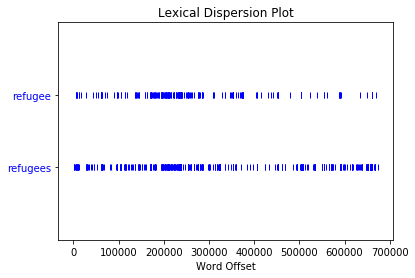

In [21]:
#Lexical Dispersion Plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
post_text.dispersion_plot(['refugee', 'refugees'])
sns.set() #Re-enabling seaborn

In [22]:
#Most common POS
def get_most_common_POS(data, years, genre=None):
    for yr in years:
        if genre:
            yearly = data[(data['genre']==genre) & (data['year']==yr)]
        else:
            yearly = data[data['year']==yr]
        freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in yearly['normalized_words_POS'].sum())
        print(yr)
        print("Most Common Nouns")
        print(freqdist_POStoWord['NN'].most_common(10))
        print()
        print("Most Common Adj")
        print(freqdist_POStoWord['JJ'].most_common(10))
        print()
        print("Most Common Verbs")
        print(freqdist_POStoWord['VB'].most_common(10))
        print()

In [23]:
years = sorted(data['year'].unique())
genres = data['genre'].unique()
genres

array(['MAG', 'SPOK', 'NEWS'], dtype=object)

In [24]:
get_most_common_POS(data, years)

1990
Most Common Nouns
[('time', 980), ('government', 940), ('today', 874), ('world', 802), ('country', 781), ('war', 687), ('way', 665), ('year', 610), ('day', 460), ('money', 420)]

Most Common Adj
[('other', 1195), ('many', 820), ('new', 762), ('american', 638), ('last', 600), ('good', 573), ('iraqi', 571), ('military', 518), ('first', 513), ('soviet', 481)]

Most Common Verbs
[('be', 3589), ('have', 1334), ('do', 853), ('get', 709), ('go', 560), ('think', 486), ('take', 482), ('make', 476), ('say', 455), ('see', 407)]

1991
Most Common Nouns
[('war', 1349), ('time', 1282), ('government', 1106), ('today', 1071), ('country', 925), ('way', 893), ('world', 790), ('year', 703), ('day', 602), ('problem', 559)]

Most Common Adj
[('other', 1437), ('many', 1073), ('iraqi', 849), ('american', 841), ('new', 832), ('last', 810), ('good', 767), ('first', 687), ('political', 653), ('own', 568)]

Most Common Verbs
[('be', 4783), ('have', 1995), ('do', 1254), ('get', 888), ('go', 874), ('say', 709

2006
Most Common Nouns
[('time', 756), ('world', 485), ('day', 474), ('government', 461), ('country', 460), ('way', 453), ('today', 417), ('war', 382), ('year', 376), ('city', 374)]

Most Common Adj
[('other', 669), ('many', 629), ('new', 586), ('last', 414), ('israeli', 399), ('first', 386), ('old', 354), ('good', 325), ('american', 310), ('little', 284)]

Most Common Verbs
[('be', 2140), ('have', 812), ('get', 546), ('do', 510), ('see', 395), ('go', 387), ('take', 368), ('make', 327), ('say', 262), ('come', 250)]

2007
Most Common Nouns
[('time', 537), ('war', 467), ('government', 419), ('world', 401), ('year', 395), ('country', 336), ('way', 331), ('today', 327), ('life', 310), ('day', 298)]

Most Common Adj
[('other', 493), ('many', 410), ('new', 392), ('last', 295), ('first', 287), ('american', 278), ('good', 248), ('political', 227), ('own', 216), ('old', 209)]

Most Common Verbs
[('be', 1640), ('have', 715), ('do', 473), ('get', 349), ('go', 293), ('make', 269), ('see', 255), ('

In [25]:
# Word Cloud by year
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    if words==0:
        continue
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    wc.to_file('wordcloud/data_{}_All.png'.format(yr))

In [26]:
def get_nouns_and_adj(data):
    noun_adj = []
    for word, pos in data['normalized_words_POS'].sum():
        if pos.startswith('NN') or pos.startswith('JJ'):
            noun_adj.append(word)
    return noun_adj

for yr in years:
    yearly = data[data['year']==yr]
    words = get_nouns_and_adj(yearly)
    if len(words)==0:
        continue
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    wc.to_file('wordcloud/data_{}_Nouns_Adj.png'.format(yr))

In [27]:
# collocations
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    
    data_bigrams = nltk.collocations.BigramCollocationFinder.from_words(words)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    print(yr)
    print(data_bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:5])
    
    data_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(words)
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    print(data_trigrams.score_ngrams(trigram_measures.likelihood_ratio)[:5])
    
# other options include student_t, chi_sq, likelihood_ratio, pmi

1990
[(('saddam', 'hussein'), 4975.3000633817965), (('saudi', 'arabia'), 4468.77823686847), (('soviet', 'union'), 3814.973152812007), (('ms', 'woodruff'), 3800.0427379481403), (('khmer', 'rouge'), 3181.06363674265)]
[(('saddam', 'hussein', 'kuwait'), 7528.188845999903), (('iraq', 'saddam', 'hussein'), 7527.69874376261), (('remove', 'saddam', 'hussein'), 7523.164286928653), (('saddam', 'hussein', 'withdraw'), 7520.873422546177), (('convince', 'saddam', 'hussein'), 7515.815911734535)]
1991
[(('saddam', 'hussein'), 7233.640426347673), (('soviet', 'union'), 4000.061797308823), (('abc', 'news'), 3292.8134861824246), (('ms', 'woodruff'), 3049.781403190526), (('middle', 'east'), 2962.7580104851677)]
[(('overthrow', 'saddam', 'hussein'), 11131.85845935476), (('rid', 'saddam', 'hussein'), 11002.29370495804), (('saddam', 'hussein', 'power'), 10986.574723963724), (('iraq', 'saddam', 'hussein'), 10980.383777370604), (('anti', 'saddam', 'hussein'), 10932.450334906178)]
1992
[(('ms', 'woodruff'), 27

[(('george', 'stephanopou', 'camera'), 2934.5924687457964), (('break', 'jim', 'lehrer'), 2255.709109977605), (('even', 'jim', 'lehrer'), 2026.4930750715794), (('jim', 'lehrer', 'newshour'), 2001.491111993685), (('jim', 'lehrer', 'agree'), 1995.9352285269538)]
2008
[(('barack', 'obama'), 691.9895514679515), (('hillary', 'clinton'), 661.8094263358976), (('ben', 'affleck-1acto'), 591.881163170404), (('prime', 'minister'), 561.3580582865952), (('yellow', 'river'), 551.696022965491)]
[(('barack', 'obama', 's'), 1158.3307065616623), (('barack', 'obama', 'white'), 1099.605926094233), (('sen', 'barack', 'obama'), 1097.038090723389), (('clinton', 'barack', 'obama'), 1092.9270422115926), (('barack', 'obama', 'hillary'), 1078.538454839801)]
2009
[(('unidentified', 'male'), 1500.3801930209024), (('jim', 'lehrer'), 1480.434420918737), (('amanpour-1voice', 'o'), 945.8961973217494), (('margaret', 'warner'), 883.7170228276138), (('jeffrey', 'brown'), 753.115892973916)]
[(('unidentified', 'male', 'tran

### Country Analysis

In [337]:
from country_list import countries_for_language
countries = dict(countries_for_language('en'))

In [379]:
years = sorted(data.year.unique())
countrylist = list(c.lower() for c in countries.values())
countrylist_all = countrylist + ['soviet', 'palestine']
countrylist_all

In [399]:
country_byyr = {}
for yr in years:
    for word in data[data['year']==yr]['tokenized_words'].sum():
        if word in countrylist_all:
            if yr not in country_byyr:
                country_byyr[yr] = {}
            if word not in country_byyr[yr]:
                country_byyr[yr][word] = 1
            else:
                country_byyr[yr][word] +=1

In [400]:
for yr in years:
    print(yr)
    print(country_byyr[yr])

1990
{'cuba': 67, 'mexico': 28, 'georgia': 24, 'jordan': 325, 'france': 89, 'vietnam': 242, 'honduras': 12, 'peru': 18, 'haiti': 14, 'china': 80, 'brazil': 17, 'bolivia': 7, 'ecuador': 3, 'germany': 222, 'russia': 55, 'poland': 75, 'greece': 10, 'bulgaria': 10, 'romania': 20, 'albania': 6, 'hungary': 49, 'lithuania': 103, 'latvia': 10, 'estonia': 11, 'finland': 24, 'turkey': 63, 'soviet': 954, 'austria': 16, 'kuwait': 802, 'iraq': 998, 'bangladesh': 20, 'india': 39, 'pakistan': 19, 'thailand': 25, 'philippines': 25, 'syria': 67, 'iran': 202, 'malawi': 9, 'mozambique': 41, 'israel': 321, 'argentina': 3, 'ethiopia': 17, 'egypt': 118, 'grenada': 13, 'japan': 207, 'afghanistan': 29, 'chad': 5, 'angola': 7, 'kenya': 8, 'panama': 150, 'ukraine': 12, 'tunisia': 6, 'nicaragua': 56, 'guatemala': 13, 'cambodia': 156, 'taiwan': 30, 'singapore': 24, 'australia': 10, 'bermuda': 1, 'indonesia': 13, 'malaysia': 10, 'fiji': 2, 'spain': 18, 'jamaica': 5, 'uruguay': 2, 'canada': 28, 'nigeria': 7, 'venez

## Calculating Divergence

In [28]:
# def kl_divergence(X, Y):
#     P = X.copy()
#     Q = Y.copy()
#     P.columns = ['P']
#     Q.columns = ['Q']
#     df = Q.join(P).fillna(0)
#     p = df.iloc[:,1]
#     q = df.iloc[:,0]
#     D_kl = scipy.stats.entropy(p, q)
#     return D_kl

# def chi2_divergence(X,Y):
#     P = X.copy()
#     Q = Y.copy()
#     P.columns = ['P']
#     Q.columns = ['Q']
#     df = Q.join(P).fillna(0)
#     p = df.iloc[:,1]
#     q = df.iloc[:,0]
#     return scipy.stats.chisquare(p, q).statistic

# def Divergence(corpus1, corpus2, difference="KL"):
#     """Difference parameter can equal KL, Chi2, or Wass"""
#     freqP = nltk.FreqDist(corpus1)
#     P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
#     freqQ = nltk.FreqDist(corpus2)
#     Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
#     if difference == "KL":
#         return kl_divergence(P, Q)
#     elif difference == "Chi2":
#         return chi2_divergence(P, Q)
#     elif difference == "KS":
#         try:
#             return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
#         except:
#             return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
#     elif difference == "Wasserstein":
#         try:
#             return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
#         except:
#             return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [29]:
# def plot_div_heatmap(corpora, fileids, diff_measure='KL'):
#     '''
#     Diff measure = KL, Chi2, KS or Wasserstein
#     '''
#     L = []
#     for p in corpora:
#         l = []
#         for q in corpora:
#             l.append(Divergence(p,q, difference = diff_measure))
#         L.append(l)
#     M = np.array(L)
#     fig = plt.figure()
#     div = pd.DataFrame(M, columns = fileids, index = fileids)
#     ax = sns.heatmap(div)
#     plt.show()

In [30]:
# TO CHECK
#corpora = data['normalized_words'][:2].sum()
# corpora = []
# for index, row in data.iterrows():
#     corpora.append(row['tokenized_words'])
#fileids = list(data['text_id'][:2])
#plot_div_heatmap(corpora, fileids,diff_measure='KL')

## Word Networks

In [31]:
# def wordCooccurrence(sentences, makeMatrix = False):
#     words = set()
#     for sent in sentences:
#         words |= set(sent)
#     wordLst = list(words)
#     wordIndices = {w: i for i, w in enumerate(wordLst)}
#     wordCoCounts = {}
#     #consider a sparse matrix if memory becomes an issue
#     coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
#     for sent in sentences:
#         for i, word1 in enumerate(sent):
#             word1Index = wordIndices[word1]
#             for word2 in sent[i + 1:]:
#                 coOcMat[word1Index][wordIndices[word2]] += 1
#     if makeMatrix:
#         return coOcMat, wordLst
#     else:
#         coOcMat = coOcMat.T + coOcMat
#         g = nx.convert_matrix.from_numpy_matrix(coOcMat)
#         g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
#         return g

# def connected_component_subgraphs(G):
#     for c in nx.connected_components(G):
#         yield G.subgraph(c)

# def posCooccurrence(sentences, *posType, makeMatrix = False):
#     words = set()
#     reducedSents = []
#     #Only using the first kind of POS for each word
#     wordsMap = {}
#     for sent in sentences:
#         s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
#         for w, t in s:
#             if w not in wordsMap:
#                 wordsMap[w] = t
#         reducedSent = [w for w, t in s]
#         words |= set(reducedSent)
#         reducedSents.append(reducedSent)
#     wordLst = list(words)
#     wordIndices = {w: i for i, w in enumerate(wordLst)}
#     wordCoCounts = {}
#     #consider a sparse matrix if memory becomes an issue
#     coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
#     for sent in reducedSents:
#         for i, word1 in enumerate(sent):
#             word1Index = wordIndices[word1]
#             for word2 in sent[i + 1:]:
#                 coOcMat[word1Index][wordIndices[word2]] += 1
#     if makeMatrix:
#         return coOcMat, wordLst
#     else:
#         coOcMat = coOcMat.T + coOcMat
#         g = nx.convert_matrix.from_numpy_matrix(coOcMat)
#         g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
#         for w in g.nodes:
#             g.nodes[w]['bipartite'] = wordsMap[w]
#         return g

# def plot_word_graph(graph):
#     layout = nx.spring_layout(graph, weight='weight', iterations= 100)
#     fig, ax = plt.subplots(figsize = (10,10))
#     nx.draw(graph, ax = ax, pos = layout, labels = {n:n for n in graph.nodes()},
#             width=.2, 
#             alpha = .9, 
#             node_size = 100,
#             node_color = "xkcd:light red",
#             edge_color='xkcd:black')

# def plot_word_centrality(g):
#     layout_nn = nx.spring_layout(g, weight='weight', iterations= 100)
#     fig, ax = plt.subplots(figsize = (10,10))
#     centralities_nn = nx.eigenvector_centrality(g)
#     maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
#     #maxWeight = max((d['weight'] for n1, n2, d in g.edges(data = True)))
#     #minWeight = min((d['weight'] for n1, n2, d in g.edges(data = True)))
#     nx.draw(g, ax = ax, pos = layout_nn, labels = {n: n for n in g.nodes()},
#             #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
#             alpha = .9, 
#             node_color = [centralities_nn[n] / maxC for n in g.nodes],
#             node_size = [centralities_nn[n] / maxC * 100 for n in g.nodes],
#             font_size = 16,
#             font_color = 'xkcd:dark grey',
#             edge_color = 'xkcd:medium blue',
#             cmap = plt.get_cmap('plasma'),
#            )

### plot word network

In [32]:
# plot word network
#g = wordCooccurrence(data['normalized_sents'].sum())
#len(g)

In [33]:
# weight_choice = 25
# # remove if less than 25
# g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= weight_choice])
# #since we are changing the graph list() evaluates the isolates first
# g.remove_nodes_from(list(nx.isolates(g)))
# # keep just the giant connected component
# main_graph = max(connected_component_subgraphs(g), key=len)
# print(nx.info(main_graph))

In [34]:
# plot_word_graph(main_graph)

In [35]:
# # plot sub-graph
# immigrant_neighbors = main_graph.neighbors('family')
# subgraph_immigrant = main_graph.subgraph(immigrant_neighbors)
# print(nx.info(subgraph_immigrant))

# plot_word_graph(subgraph_immigrant)

In [36]:
# # cliques
# print(', '.join(max(nx.clique.find_cliques(main_graph), key = lambda x: len(x))))

### plot word network by pos

In [37]:
# # plot pos network
# gNV = posCooccurrence(data['normalized_sents'].sum(), 'NN', 'VB')
# print(nx.info(gNV))

In [38]:
# degree_threshold= 100
# weight_threshold = 2
# gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= degree_threshold]) 
# print(nx.info(gNV))
# gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= weight_threshold])
# print(nx.info(gNV))

In [39]:
# #TO CHECK
# plot_word_centrality(gNV)

In [40]:
# # draw egocentric network
# g_immigrant_NV = gNV.subgraph(['family'] + list(gNV.neighbors('family')))
# print(nx.info(g_immigrant_NV))

In [41]:
# nx.draw_networkx(g_immigrant_NV)

### centrality & global measures

In [42]:
# #centralities

# centralities = nx.degree_centrality(main_graph)
# #centralities = nx.eigenvector_centrality(main_graph)
# #centralities = nx.closeness_centrality(main_graph)
# #centralities = nx.betweenness.betweenness_centrality(main_graph)
# plt.hist(list(centralities.values()))
# plt.show()

In [43]:
# name = 'degree'

# centrality_df = pd.DataFrame.from_dict(centralities, orient='index', columns=[name])
# centrality_df.sort_values(by=name, ascending=False, inplace=True)
# #highest 10
# centrality_df[:10]

In [44]:
# #global measures
# density = nx.density(main_graph)
# mean_degree_pernode = np.mean([v for w,v in nx.degree(main_graph)])
# diameter = nx.diameter(main_graph)
# print(
# "The density of this graph is {}\n\
# Mean degree per node is {}\n\
# Diameter of graph is {}".format(density, mean_degree_pernode, diameter))

## Cross-sectional Clustering

For 2 clusters, average silhouette score is 0.025361911885286685
For 3 clusters, average silhouette score is 0.02234259584398125
For 4 clusters, average silhouette score is 0.02657326560423425
For 5 clusters, average silhouette score is 0.027636167261981114
For 6 clusters, average silhouette score is 0.02939300239977569
For 7 clusters, average silhouette score is 0.034407616342643686
For 8 clusters, average silhouette score is 0.035382238958076
For 9 clusters, average silhouette score is 0.03886473020762334


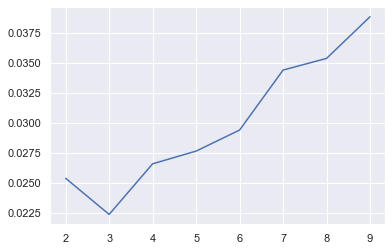

In [45]:
def find_best_n(X, max=10):
    clusters = []
    s_avg = []
    for i in range(2, max):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        clusters.append(i)
        s_avg.append(silhouette_avg)
        print("For {} clusters, average silhouette score is {}".format(i, silhouette_avg))
    plt.plot(clusters, s_avg)
    plt.show()

X = dataVects.toarray()
find_best_n(X)

In [46]:
num_cluster = 9
km = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')
km.fit(dataVects)
data['kmeans_prediction'] = km.labels_

In [47]:
def get_top_words(km, num_cluster, data_vectoriser):
    terms = data_vectoriser.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(num_cluster):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind])
        print('\n')

get_top_words(km, num_cluster, data_vectoriser)

Top terms per cluster:
Cluster 0:
 iraq
 iraqi
 saddam
 kuwait
 baghdad
 iraqis
 hussein
 al
 bush
 troops
 military
 koppel
 forces
 iran
 saudi
 mr
 gulf
 jordan
 turkey
 syria


Cluster 1:
 military
 bosnia
 kosovo
 serbs
 nato
 peace
 troops
 army
 international
 serb
 bosnian
 russian
 aid
 nations
 forces
 soviet
 muslim
 officials
 ethnic
 foreign


Cluster 2:
 immigrants
 immigration
 asylum
 illegal
 border
 legal
 law
 percent
 mexico
 countries
 refugee
 mr
 europe
 federal
 chinese
 america
 population
 san
 california
 policy


Cluster 3:
 voiceover
 qwq
 footage
 mr
 unidentified
 ms
 simon
 camera
 yeah
 nt
 yes
 dr
 ve
 got
 smith
 woman
 really
 mean
 al
 photo


Cluster 4:
 women
 school
 church
 mother
 father
 san
 black
 water
 god
 young
 students
 story
 community
 book
 south
 music
 money
 america
 white
 small


Cluster 5:
 clinton
 really
 ve
 voice
 cnn
 lot
 news
 yes
 judy
 mean
 ll
 woodruff
 obama
 abc
 let
 got
 thank
 clip
 look
 video


Cluster 6:
 is

In [48]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    
    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")    
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


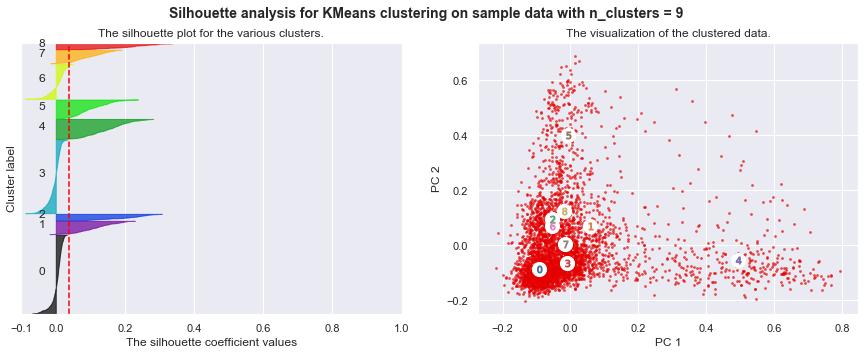

For n_clusters = 9, The average silhouette_score is : 0.039


In [49]:
plotSilhouette(num_cluster, X)

In [50]:
def plot_clusters(dataVects, km, num_cluster, terms=data_vectoriser.get_feature_names()):
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    # get distinguishing words to label
    components = pca.components_
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
    words = [terms[i] for i in keyword_ids]#Turn the ids into words.
    x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
    y = components[:,keyword_ids][1,:]
    
    cmap = matplotlib.cm.get_cmap("viridis")
    colors_p = [cmap(l/num_cluster) for l in km.labels_]
    
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))
    plt.xticks(())
    plt.yticks(())
    plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
    plt.show()

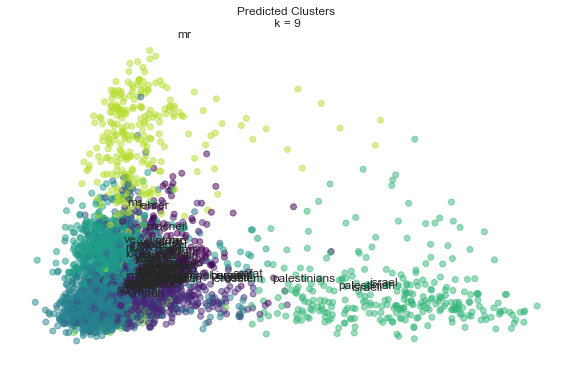

In [51]:
plot_clusters(dataVects, km, num_cluster)

## Cross-sectional Topic Modelling

In [52]:
# creating dictionary
dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]
# serialize
gensim.corpora.MmCorpus.serialize('data.mm', corpus)
data_mm = gensim.corpora.MmCorpus('data.mm')
# topic modelling
topics=10
data_lda = gensim.models.ldamodel.LdaModel(corpus=data_mm, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')

In [53]:
data_lda.save("data_lda")

In [54]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:n][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title, n)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pd.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title, N):
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

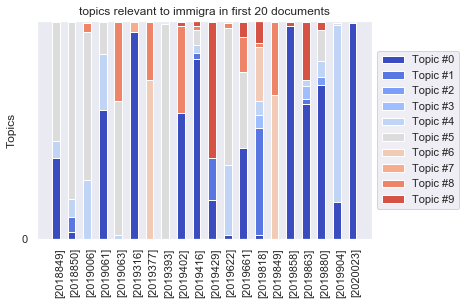

,text_id,title,year,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2018849,This is the land of opportunity.,1990,"[(0, 0.36889943), (4, 0.08046423), (5, 0.54796...",0.368899,0.000000,0.000000,0.000000,0.080464,0.547964,0.000000,0.000000,0.000000,0.000000
1,2018850,Betting on regional booms.,1990,"[(0, 0.029493755), (1, 0.069249645), (4, 0.081...",0.029494,0.069250,0.000000,0.000000,0.081514,0.817814,0.000000,0.000000,0.000000,0.000000
2,2019006,The evolution of jeans.,1990,"[(4, 0.2688296), (5, 0.6829013), (8, 0.0417117...",0.000000,0.000000,0.000000,0.000000,0.268830,0.682901,0.000000,0.000000,0.041712,0.000000
3,2019061,Serve the people.,1990,"[(0, 0.5937421), (4, 0.25496498), (5, 0.147929...",0.593742,0.000000,0.000000,0.000000,0.254965,0.147929,0.000000,0.000000,0.000000,0.000000
4,2019063,No road to Tahuanti.,1990,"[(4, 0.015372943), (5, 0.61566514), (8, 0.3674...",0.000000,0.000000,0.000000,0.000000,0.015373,0.615665,0.000000,0.000000,0.367490,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987,4123518,"The Crisis In Syria, On A Human Level",2012,"[(2, 0.31221035), (6, 0.1195278), (7, 0.022988...",0.000000,0.000000,0.312210,0.000000,0.000000,0.000000,0.119528,0.022988,0.538328,0.000000
3988,4123545,"PBS NewsHour For July 26, 2012",2012,"[(1, 0.07971561), (2, 0.059588734), (3, 0.3002...",0.000000,0.079716,0.059589,0.300289,0.522610,0.014794,0.000000,0.000000,0.000000,0.020505
3989,4123547,"PBS NewsHour For July 13, 2012",2012,"[(1, 0.0569288), (3, 0.3219169), (4, 0.4214116...",0.000000,0.056929,0.000000,0.321917,0.421412,0.000000,0.000000,0.000000,0.000000,0.186837
3990,4123584,"For December 14, 2012, CBS",2012,"[(1, 0.04632798), (2, 0.37540755), (3, 0.23359...",0.000000,0.046328,0.375408,0.233594,0.010960,0.011480,0.000000,0.092874,0.000000,0.218172


In [55]:
n=20
title = "topics relevant to immigra in first {} documents".format(n)
plot_topics(data_lda, dictionary, data, title, n=n)

In [56]:
for i in range(data_lda.num_topics):
    print(i)
    print(data_lda.show_topic(i, topn=10))

0
[('refugee', 0.015359014), ('school', 0.006565042), ('clinton', 0.006260147), ('group', 0.006194174), ('nation', 0.0061245365), ('law', 0.005850806), ('child', 0.0056906627), ('immigration', 0.0052598105), ('church', 0.004961539), ('party', 0.0049062343)]
1
[('military', 0.008935243), ('refugee', 0.0082052285), ('iraq', 0.0067091547), ('fight', 0.0055613588), ('policy', 0.0053354357), ('leader', 0.0052078674), ('russian', 0.0052016834), ('foreign', 0.005109881), ('official', 0.005099473), ('army', 0.0049035363)]
2
[('yes', 0.013008336), ('king', 0.009263771), ('question', 0.00842788), ('thank', 0.0075423256), ('lot', 0.0072924052), ('john', 0.0064124474), ('news', 0.0061940113), ('issue', 0.0056987223), ('david', 0.0055196197), ('point', 0.0054351846)]
3
[('issue', 0.0065764696), ('david', 0.0062067294), ('woman', 0.0059639052), ('question', 0.0057430756), ('thank', 0.005657148), ('yes', 0.005594072), ('case', 0.005575082), ('lot', 0.005514665), ('nation', 0.00545599), ('problem', 0.

## Dynamic Topic Modelling

Read documentation: https://radimrehurek.com/gensim/models/ldaseqmodel.html

In [57]:
# Yearly
docs_per_year = list(data.groupby('year').size())
num_topics = 5
data_ldaseq_yearly = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [58]:
data_ldaseq_yearly.save("data_ldaseq_yearly")

In [59]:
data_ldaseq_yearly.print_topic_times(topic=0, top_terms=10)

[[('vietnam', 0.024968650916250446),
  ('john', 0.018537393154611486),
  ('king', 0.018111101303897866),
  ('news', 0.013151800137901336),
  ('lot', 0.012819078208112315),
  ('voice', 0.012449703058178684),
  ('peter', 0.011724234927896624),
  ('george', 0.00991546036741817),
  ('break', 0.00975604821155596),
  ('question', 0.009679367645348139)],
 [('king', 0.019644406296388427),
  ('john', 0.01806327226833807),
  ('vietnam', 0.017046515339688918),
  ('voice', 0.013684256983832646),
  ('news', 0.013610244727737614),
  ('lot', 0.013296323116753684),
  ('peter', 0.011830845337251919),
  ('question', 0.010280200608658667),
  ('abc', 0.010234179466865702),
  ('break', 0.010153268912035227)],
 [('king', 0.021714739210250487),
  ('john', 0.016966093508905555),
  ('voice', 0.015772441185744467),
  ('news', 0.015386941325735343),
  ('abc', 0.012997558209234544),
  ('vietnam', 0.012940605356240528),
  ('peter', 0.012753626105893423),
  ('lot', 0.01257717186563318),
  ('jennings', 0.01200493490

In [60]:
data_ldaseq_yearly.print_topic_times(topic=1, top_terms=10)

[[('refugee', 0.01679931737712837),
  ('military', 0.014013545945763541),
  ('army', 0.011054072263457674),
  ('soviet', 0.010855888324243777),
  ('nation', 0.00901784212420437),
  ('official', 0.008276817062837557),
  ('europe', 0.008156008695459634),
  ('fight', 0.008018614551240321),
  ('germany', 0.00797991152977498),
  ('leader', 0.007929315209285128)],
 [('military', 0.017515716988768037),
  ('army', 0.012739314046637244),
  ('refugee', 0.011947358561668796),
  ('nation', 0.009339661160647234),
  ('fight', 0.009139893646435873),
  ('leader', 0.008532679125923091),
  ('bosnia', 0.008502576818274689),
  ('general', 0.008113771556192547),
  ('north', 0.007816862348323472),
  ('official', 0.0077830702084159065)],
 [('military', 0.019942093885223847),
  ('army', 0.014529030831551711),
  ('north', 0.01247831051585107),
  ('refugee', 0.011012847487814583),
  ('fight', 0.010113081692248905),
  ('nation', 0.00902298142355162),
  ('general', 0.008149765295881102),
  ('kill', 0.008032806171

In [61]:
data_ldaseq_yearly.print_topic_times(topic=2, top_terms=10)

[[('israel', 0.0329726119273318),
  ('israeli', 0.02189305868557417),
  ('iraq', 0.020652474987601557),
  ('palestinian', 0.01945127544385338),
  ('peace', 0.016906837380504185),
  ('saddam', 0.014791893632394696),
  ('arab', 0.01462220749899193),
  ('middle', 0.013835546729697031),
  ('iraqi', 0.011920274690296224),
  ('east', 0.011861729184198734)],
 [('israel', 0.02824303452461222),
  ('iraq', 0.025144151535687706),
  ('israeli', 0.018261600389282807),
  ('palestinian', 0.015724354253466164),
  ('saddam', 0.015703173627910797),
  ('peace', 0.014626984351217802),
  ('arab', 0.013740302277004762),
  ('iraqi', 0.012542405938649508),
  ('middle', 0.012114896223393633),
  ('al', 0.011251421353820477)],
 [('iraq', 0.036049268339442206),
  ('israel', 0.026900685248744043),
  ('israeli', 0.01662694002219319),
  ('saddam', 0.014858228623256933),
  ('al', 0.014262321352173446),
  ('palestinian', 0.01424829281590758),
  ('iraqi', 0.014139906363266806),
  ('peace', 0.012973277541570903),
  ('ar

In [62]:
data_ldaseq_yearly.print_topic_times(topic=3, top_terms=10)

[[('company', 0.011456208767167327),
  ('policy', 0.010848735732641916),
  ('business', 0.010692877589746446),
  ('economic', 0.01055805950546584),
  ('service', 0.009998183727537472),
  ('issue', 0.008519071507667706),
  ('percent', 0.008459968524789075),
  ('market', 0.007944020375625567),
  ('job', 0.007476819004219141),
  ('economy', 0.007252905575705809)],
 [('company', 0.011598494958520526),
  ('business', 0.010129676331066517),
  ('policy', 0.009951839328718058),
  ('economic', 0.009839452180802667),
  ('issue', 0.009136404165449693),
  ('clinton', 0.009098404652775574),
  ('percent', 0.00848064893497979),
  ('service', 0.00834648515898967),
  ('job', 0.007460571208135567),
  ('market', 0.007244488082283541)],
 [('company', 0.011027542871431316),
  ('policy', 0.00950167785492103),
  ('business', 0.009292911827387888),
  ('issue', 0.008610388224989883),
  ('percent', 0.008417476826160732),
  ('economic', 0.008152542608149878),
  ('program', 0.007091641021577093),
  ('problem', 0.

In [63]:
data_ldaseq_yearly.print_topic_times(topic=4, top_terms=10)

[[('woman', 0.018911765121666136),
  ('child', 0.013358963061991547),
  ('black', 0.009806509901098184),
  ('photo', 0.008752086863084265),
  ('late', 0.007619618563998448),
  ('church', 0.0074432169726731615),
  ('school', 0.006942133696033776),
  ('young', 0.006940604794849891),
  ('land', 0.00646743357408672),
  ('small', 0.006351376916113445)],
 [('woman', 0.01697602669184965),
  ('child', 0.015020381450189057),
  ('black', 0.009291572478664564),
  ('church', 0.00928894106248706),
  ('late', 0.00752418393624119),
  ('school', 0.007103633280790431),
  ('young', 0.006701658764743701),
  ('father', 0.006251527393805564),
  ('god', 0.006222525053396845),
  ('turn', 0.006163747452221345)],
 [('woman', 0.01958229706905225),
  ('child', 0.012879230586935889),
  ('school', 0.008215368915052944),
  ('water', 0.008059454775706201),
  ('church', 0.008058866093088158),
  ('god', 0.007818173690869094),
  ('late', 0.007358633863490912),
  ('young', 0.006963555345694867),
  ('black', 0.0066661386

In [64]:
#5-year periods
def get_period(year, startyr, endyr, n=5):
    period_start = []
    for i in range(startyr, endyr+1, n):
        period_start.append(i)
    for index, p in enumerate(period_start):
        if year >= p:
            period = index
            continue
        else:
            break
    return period  
    
data['period'] = data['year'].apply(lambda x: get_period(x, 1991, 2015, n=5) if x>=1991 else 0)

In [65]:
docs_per_year = list(data.groupby('period').size())
num_topics = 10
data_ldaseq_5yr = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [66]:
data_ldaseq_5yr.save("data_ldaseq_5yr")

In [67]:
data_ldaseq_5yr.print_topic_times(topic=0)

[[('story', 0.011997048063810653),
  ('play', 0.011856620685778968),
  ('book', 0.011235768906483099),
  ('love', 0.01115288295680401),
  ('god', 0.01026059077240225),
  ('father', 0.01009910165668326),
  ('great', 0.00968274565744009),
  ('young', 0.009562756804626404),
  ('friend', 0.009276512718853613),
  ('woman', 0.00895172375447669),
  ('late', 0.008703411904409942),
  ('art', 0.008121301794706107),
  ('scene', 0.008082775495851862),
  ('photo', 0.007809375346950681),
  ('john', 0.007496491436186674),
  ('music', 0.007140311309160672),
  ('turn', 0.0068562551698520165),
  ('film', 0.0067140833654064855),
  ('movie', 0.006518343780685137),
  ('mother', 0.00648871286472615)],
 [('love', 0.012508737375148056),
  ('story', 0.012097590310471888),
  ('play', 0.011917429140478214),
  ('book', 0.011206894484725276),
  ('god', 0.009966408497998144),
  ('great', 0.009695559710116925),
  ('father', 0.00965010381050072),
  ('young', 0.009588047649613088),
  ('friend', 0.009239219947354825),


In [68]:
data_ldaseq_5yr.print_topic_times(topic=1)

[[('yes', 0.028806969191180618),
  ('voice', 0.026992615039075546),
  ('news', 0.02150451054510302),
  ('king', 0.020443337696674304),
  ('lot', 0.018621528140309127),
  ('kind', 0.01291500812601763),
  ('break', 0.012884777138332451),
  ('thank', 0.012804935967038786),
  ('question', 0.011672634533063046),
  ('camera', 0.011441412238870168),
  ('abc', 0.011014770000224394),
  ('point', 0.00981676415770963),
  ('koppel', 0.009400084301457157),
  ('actually', 0.009357196249433061),
  ('unidentified', 0.008941893054402225),
  ('john', 0.008700252748220597),
  ('commercial', 0.008604233943033546),
  ('peter', 0.00841948760655039),
  ('story', 0.008163071248583079),
  ('big', 0.008019588458096702)],
 [('yes', 0.02833864438530657),
  ('voice', 0.022190456304155694),
  ('king', 0.019494313909800387),
  ('lot', 0.018328205920329303),
  ('thank', 0.018289691989903586),
  ('unidentified', 0.017850007131106144),
  ('news', 0.014600146542471494),
  ('cnn', 0.014473567958945917),
  ('kind', 0.0126

In [69]:
data_ldaseq_5yr.print_topic_times(topic=2)

[[('clinton', 0.020239370204147233),
  ('ms', 0.01827929809934394),
  ('lehrer', 0.015199930480485025),
  ('bush', 0.011121411212302302),
  ('issue', 0.010499892024482444),
  ('sen', 0.010338627989147423),
  ('vote', 0.010270296152845138),
  ('congress', 0.009953564492194531),
  ('problem', 0.009850053730905927),
  ('policy', 0.009599550583170576),
  ('macneil', 0.008551296319730577),
  ('question', 0.00825996436162675),
  ('george', 0.007952155532407815),
  ('party', 0.007898650233925811),
  ('news', 0.007474858230376799),
  ('administration', 0.007401635849057625),
  ('election', 0.007266999672873812),
  ('lot', 0.0071709976266826425),
  ('senator', 0.006893387468203514),
  ('washington', 0.00687205254697819)],
 [('clinton', 0.02412623597630813),
  ('ms', 0.01763609997624993),
  ('lehrer', 0.014875097761352112),
  ('bush', 0.01088687920057783),
  ('issue', 0.010521955441947247),
  ('vote', 0.010295777826721047),
  ('congress', 0.009976970154046855),
  ('sen', 0.009976103350429482),
 

In [70]:
data_ldaseq_5yr.print_topic_times(topic=3)

[[('israel', 0.06452911342535098),
  ('israeli', 0.04566628125905743),
  ('palestinian', 0.03702655580836323),
  ('peace', 0.024819217046764763),
  ('palestinians', 0.02420044695540313),
  ('gaza', 0.015488287602140202),
  ('arab', 0.01467783622348686),
  ('arafat', 0.014638199318989924),
  ('west', 0.014488840131754496),
  ('israelis', 0.01406956891298157),
  ('jewish', 0.013657230240709951),
  ('jews', 0.013650495017192388),
  ('east', 0.012576554203142997),
  ('bank', 0.012375378450120144),
  ('jerusalem', 0.012227025752071487),
  ('minister', 0.011679787206379903),
  ('lebanon', 0.0111608340695388),
  ('hamas', 0.011060477177049208),
  ('leader', 0.009493163473835881),
  ('prime', 0.009257195032613205)],
 [('israel', 0.06407265094605655),
  ('israeli', 0.04578930580922905),
  ('palestinian', 0.03746143149356086),
  ('peace', 0.024658902356093748),
  ('palestinians', 0.024231706378202558),
  ('gaza', 0.015738823044814252),
  ('minister', 0.014792104078420151),
  ('arafat', 0.0146565

In [71]:
data_ldaseq_5yr.print_topic_times(topic=4)

[[('company', 0.01735422741788748),
  ('north', 0.013665170756227309),
  ('business', 0.013275216577063861),
  ('water', 0.012177635731664761),
  ('market', 0.011933973787985261),
  ('china', 0.01033234349785343),
  ('build', 0.009502341868167926),
  ('large', 0.008592540028033165),
  ('area', 0.00849652695818961),
  ('job', 0.00841513112736303),
  ('percent', 0.008281640466118876),
  ('big', 0.007734790836775343),
  ('oil', 0.007675565181069261),
  ('price', 0.007431399841487951),
  ('south', 0.007252106282466086),
  ('park', 0.007130547912810981),
  ('economy', 0.007070619152713439),
  ('small', 0.007003208998403613),
  ('plan', 0.0068969843466518636),
  ('trade', 0.006857687844529606)],
 [('company', 0.01728987708598829),
  ('north', 0.013771651200640382),
  ('business', 0.012954116722498235),
  ('market', 0.0120617358960142),
  ('water', 0.011443254686124772),
  ('china', 0.010446467541412393),
  ('build', 0.009256878541879834),
  ('area', 0.008705766726769171),
  ('percent', 0.008

In [74]:
data_ldaseq_5yr.print_topic_times(topic=5)

[[('iraq', 0.043391669838371345),
  ('iraqi', 0.02010678550144065),
  ('military', 0.018943198108225884),
  ('al', 0.018858619720063138),
  ('saddam', 0.017652397747264188),
  ('hussein', 0.013812701869679292),
  ('afghanistan', 0.012714778683868956),
  ('kuwait', 0.012459633125280771),
  ('attack', 0.01072848863598494),
  ('bush', 0.01053144126172781),
  ('taliban', 0.009897219390591197),
  ('official', 0.009897215243950902),
  ('security', 0.009760503135656294),
  ('saudi', 0.009365673251957403),
  ('iran', 0.00906716371413161),
  ('baghdad', 0.00822329322261587),
  ('fight', 0.008154133728818966),
  ('report', 0.007956823695867725),
  ('gulf', 0.007768846887193484),
  ('pakistan', 0.007633817568657246)],
 [('iraq', 0.04327273035260853),
  ('iraqi', 0.020039336457276284),
  ('al', 0.019253906857105936),
  ('military', 0.018801873057855367),
  ('saddam', 0.016657234121410482),
  ('afghanistan', 0.012977141102553586),
  ('hussein', 0.012904655397677047),
  ('kuwait', 0.0113342378444790

In [75]:
data_ldaseq_5yr.print_topic_times(topic=6)

[[('refugee', 0.0322397892944523),
  ('child', 0.026117177079915017),
  ('camp', 0.017476978126007042),
  ('kill', 0.01565611585912968),
  ('food', 0.014734511146434271),
  ('aid', 0.013462205779910327),
  ('woman', 0.011427323171009232),
  ('ms', 0.011098965172766869),
  ('month', 0.010774023048214489),
  ('south', 0.010492265443390528),
  ('africa', 0.009994841404838943),
  ('village', 0.009179772701748218),
  ('border', 0.009008986802177309),
  ('return', 0.008694034301986677),
  ('town', 0.008606313967157832),
  ('die', 0.008409747590170361),
  ('fight', 0.008132359620456496),
  ('water', 0.008015763204465775),
  ('area', 0.007757856722388096),
  ('relief', 0.007710154051852252)],
 [('refugee', 0.03272826955227782),
  ('child', 0.02609054031346353),
  ('camp', 0.017870447467519892),
  ('kill', 0.01570496320750813),
  ('food', 0.014697075789128065),
  ('aid', 0.013411077043465874),
  ('woman', 0.01133624680335199),
  ('month', 0.010877375413975465),
  ('ms', 0.010590164734846051),
 

In [76]:
data_ldaseq_5yr.print_topic_times(topic=7)

[[('woodruff', 0.027879481299968707),
  ('judy', 0.017758870257884148),
  ('obama', 0.013905074969011857),
  ('warner', 0.012351566482847968),
  ('brown', 0.012173642645995589),
  ('lot', 0.011899111631060935),
  ('suarez', 0.011695603103561911),
  ('margaret', 0.011510175147989687),
  ('thank', 0.011017864737018386),
  ('gwen', 0.00976943166272386),
  ('ifill', 0.009140529720594684),
  ('kind', 0.009014607587967953),
  ('point', 0.008982991050117321),
  ('ray', 0.008202982132707055),
  ('david', 0.008132275845501987),
  ('yes', 0.008123399065932138),
  ('paul', 0.00795184877421415),
  ('jim', 0.007779600084743701),
  ('jeffrey', 0.007656137560290376),
  ('mark', 0.007495341263853413)],
 [('woodruff', 0.02574498255764099),
  ('judy', 0.018080425033214297),
  ('obama', 0.014252768505783732),
  ('brown', 0.012754273016954134),
  ('warner', 0.011953036987344077),
  ('lot', 0.011890734981216509),
  ('margaret', 0.011349643405065018),
  ('thank', 0.011124575823490178),
  ('suarez', 0.010967

In [77]:
data_ldaseq_5yr.print_topic_times(topic=8)

[[('school', 0.02105261650864445),
  ('woman', 0.019388136246500553),
  ('child', 0.01696115489445294),
  ('student', 0.0125770356649449),
  ('law', 0.012565517624097853),
  ('community', 0.01181547049933172),
  ('church', 0.011275837795696938),
  ('group', 0.010886432678278483),
  ('program', 0.01070812272942104),
  ('health', 0.010533467585882758),
  ('court', 0.00909977537958768),
  ('immigration', 0.00909452529188775),
  ('service', 0.008525759421259318),
  ('percent', 0.008271375866238849),
  ('case', 0.008198908235595468),
  ('university', 0.008186160848192866),
  ('human', 0.007847791801162286),
  ('public', 0.007805555276293724),
  ('social', 0.007676977845205206),
  ('care', 0.00767076583359207)],
 [('school', 0.02119073069794414),
  ('child', 0.018773772626741146),
  ('woman', 0.018675254436729016),
  ('student', 0.01277778806687366),
  ('law', 0.01266461505900771),
  ('community', 0.01175950813395379),
  ('church', 0.011200177789277404),
  ('program', 0.011065757751625611),


In [78]:
data_ldaseq_5yr.print_topic_times(topic=9)

[[('military', 0.016369190681043064),
  ('bosnia', 0.013317381434549564),
  ('nato', 0.013043580014825818),
  ('europe', 0.011861956665428507),
  ('nation', 0.011154867492834196),
  ('peace', 0.011121721481721684),
  ('russian', 0.01076971801763519),
  ('army', 0.010468797828525011),
  ('soviet', 0.01039622180697319),
  ('serbs', 0.010093206245162408),
  ('germany', 0.009989916770779313),
  ('leader', 0.009969643877957112),
  ('russia', 0.009781895954250362),
  ('power', 0.008661980689958375),
  ('bosnian', 0.00807628472789918),
  ('french', 0.008028856396362334),
  ('general', 0.007780689557613348),
  ('international', 0.007600701839421977),
  ('fight', 0.007346064564786372),
  ('foreign', 0.007335611823656683)],
 [('military', 0.016148193407405278),
  ('nato', 0.01497293227227605),
  ('bosnia', 0.012916272799097177),
  ('kosovo', 0.012156128054007911),
  ('europe', 0.01194214157053519),
  ('nation', 0.011904838160009536),
  ('peace', 0.010919229714670688),
  ('russian', 0.01087674651

In [79]:
# #topic distribution divergence
# from gensim.matutils import kullback_leibler

# def plot_topic_divergence(data, years, num_topics=5, stopwords_all):
#     topic_prob, lda = get_topic_prob(data, years, num_topics, stopwords_all)
#     L = []
#     for year_1 in topic_prob.keys():
#         p = topic_prob[year_1]
#         l = []
#         for year_2 in topic_prob.keys():
#             q = topic_prob[year_2]
#             l.append(kullback_leibler(p, q))
#         L.append(l)
#     M = np.array(L)

#     fig = plt.figure()
#     div = pd.DataFrame(M, columns = list(topic_prob.keys()), index = list(topic_prob.keys()))
#     ax = sns.heatmap(div)
#     plt.show()
#     return lda
    
# def get_topic_prob(data, years, num_topics=5, stopwords_all):
#     topic_prob = {}
    
#     byyear, lda = get_topic_distribution(data, years, num_topics, stopwords_all)
#     # Convert to probability
#     for yr in years:
#         j=0
#         for i in range(10):
#             try:
#                 index, prob = byyear[yr][j]
#             except IndexError:
#                 index = False

#             if index == i:
#                 j+=1
#                 if yr in topic_prob:  
#                     topic_prob[yr].append(prob)
#                 else:
#                     topic_prob[yr] = [prob]
#             else:
#                 if yr in topic_prob:  
#                     topic_prob[yr].append(float(0))
#                 else:
#                     topic_prob[yr] = [float(0)]
#     return topic_prob, lda


# def get_topic_distribution(data, years, num_topics=5, stopwords_all):
#     byyear = {}
#     lda = {}
#     # Get topic distribution for each year
#     for yr in years:
#         # get all text for each year
#         text_df = data[data['year']==yr][['text']]
#         text_df['tokenized_text'] = text_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
#         text_df['normalized_tokens'] = text_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, extra_stop=stopwords_all))
#         # create dictionary
#         data_dictionary_byyear = gensim.corpora.Dictionary(text_df['normalized_tokens'])
#         data_corpus_byyear = [data_dictionary_byyear.doc2bow(text) for text in text_df['normalized_tokens']]
#         #lda
#         lda_byyear = gensim.models.ldamodel.LdaModel(corpus=data_corpus_byyear, id2word=data_dictionary_byyear, num_topics=num_topics, alpha='auto', eta='auto')

#         # place topic distribution in dictionary
#         all_text = []
#         for text in text_df['normalized_tokens']:
#             all_text.extend(text)
#         byyear[yr] = lda_byyear[data_dictionary_byyear.doc2bow(all_text)]
#         lda[yr] = lda_byyear

#         print('{} done'.format(yr))
#     return byyear, lda

In [82]:
def get_yearly_lda(data, years, stopwords_all, num_topics=5):
    lda = {}
    byyear = {}
    for yr in years:
        # get all text for each year
        text_df = data[data['year']==yr][['text']]
        text_df['tokenized_text'] = text_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
        text_df['normalized_tokens'] = text_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, extra_stop=stopwords_all))
        # create dictionary
        data_dictionary_byyear = gensim.corpora.Dictionary(text_df['normalized_tokens'])
        data_corpus_byyear = [data_dictionary_byyear.doc2bow(text) for text in text_df['normalized_tokens']]
        #lda
        lda_byyear = gensim.models.ldamodel.LdaModel(corpus=data_corpus_byyear, id2word=data_dictionary_byyear, num_topics=num_topics, alpha='auto', eta='auto')

        # place topic distribution in dictionary
        all_text = []
        for text in text_df['normalized_tokens']:
            all_text.extend(text)
        byyear[yr] = lda_byyear[data_dictionary_byyear.doc2bow(all_text)]
        lda[yr] = lda_byyear

        print('{} done'.format(yr), end = '\r')
    return byyear, lda

In [83]:
years = sorted(data['year'].unique())
byyear_topic_dist, lda_by_year = get_yearly_lda(data, years, stopwords_all, num_topics=5)

In [84]:
for yr in years:
    for i in range(5):
        print("Year: {}, Topic: {}".format(yr, i))
        print(lda_by_year[yr].show_topic(i, topn=10))

Year: 1990, Topic: 0
[('say', 0.005485599), ('go', 0.004941418), ('soviet', 0.0035154447), ('unite', 0.0032799991), ('state', 0.0031458684), ('get', 0.0030752867), ('american', 0.0029138573), ('iraq', 0.00281252), ('need', 0.002613838), ('have', 0.0025399697)]
Year: 1990, Topic: 1
[('say', 0.010426848), ('go', 0.0045198645), ('ms', 0.003842165), ('unite', 0.0033969744), ('iraq', 0.0032494997), ('soviet', 0.0031784782), ('state', 0.0031456992), ('kuwait', 0.0030833054), ('have', 0.0030492626), ('year', 0.0026870908)]
Year: 1990, Topic: 2
[('say', 0.008663272), ('go', 0.0061053582), ('iraq', 0.0035701655), ('state', 0.0031760982), ('ms', 0.0030329737), ('unite', 0.0028633797), ('have', 0.0025888446), ('year', 0.0025438557), ('american', 0.0024844042), ('get', 0.0024368854)]
Year: 1990, Topic: 3
[('say', 0.011832392), ('go', 0.004686687), ('iraq', 0.0039444687), ('soviet', 0.0034018096), ('unite', 0.0033005185), ('$', 0.0032891722), ('kuwait', 0.0032453344), ('iraqi', 0.003017243), ('stat

## Word Embeddings

### word2vec
 * Documentation: https://radimrehurek.com/gensim/models/word2vec.html
 * Parameters: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [178]:
data_w2v = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum(), size=100, window=5, min_count=1, workers=4) 

In [179]:
data_w2v.save('data_w2v')

In [180]:
data_w2v = gensim.models.word2vec.Word2Vec.load('data_w2v')

In [181]:
data_w2v.most_similar(positive=['refugee'])

[('migrant', 0.753075361251831),
 ('displace', 0.6984508633613586),
 ('nongovernment', 0.6907065510749817),
 ('haitians', 0.6896533370018005),
 ('concentration', 0.682991087436676),
 ('rwandans', 0.6744073033332825),
 ('reeducation', 0.65629643201828),
 ('syrians', 0.6541006565093994),
 ('cubans', 0.6530855298042297),
 ('somalis', 0.6489497423171997)]

In [182]:
data_w2v.similarity('refugee','asylumseekers')

0.2467873

In [183]:
data_w2v.most_similar(positive=['refugee', 'illegal'], negative=['legal'])

[('migrant', 0.6975387930870056),
 ('somalis', 0.6495878100395203),
 ('melk', 0.6280969977378845),
 ('displace', 0.6113077998161316),
 ('countrieshave', 0.6089671850204468),
 ('concentration', 0.6033154726028442),
 ('rwandans', 0.5957043170928955),
 ('smuggler', 0.5956036448478699),
 ('syrians', 0.5913463830947876),
 ('flee', 0.589691698551178)]

In [184]:
data_w2v.most_similar(positive=['refugee', 'independent'], negative=['dependent'])

[('talaqan', 0.5055829882621765),
 ('woodfin', 0.4929426312446594),
 ('geneva', 0.4884214997291565),
 ('warburton', 0.4871530532836914),
 ('david', 0.48254573345184326),
 ('ornithologie', 0.4621211886405945),
 ('tomasi', 0.4591229259967804),
 ('mazrak', 0.454521507024765),
 ('bonechilling', 0.4542570412158966),
 ('seculars', 0.4534222185611725)]

In [185]:
data_w2v.most_similar(positive=['refugee', 'peace'], negative=['violence'])

[('fabs', 0.5969944000244141),
 ('ingando', 0.5533397793769836),
 ('radcliff', 0.5392062664031982),
 ('seculars', 0.5242100954055786),
 ('nongovernment', 0.5229086875915527),
 ('ghais', 0.5188939571380615),
 ('bridding', 0.5049507021903992),
 ('returnee', 0.5048251748085022),
 ('mazrak', 0.5031120181083679),
 ('islahiya', 0.5027600526809692)]

In [186]:
data_w2v.similarity('refugee','assistance')

0.43924737

In [187]:
data_w2v.similarity('refugee','welfare')

0.26838502

In [188]:
data_w2v.similarity('refugee','crisis')

0.3422728

In [189]:
data_w2v.similarity('refugee','problem')

0.27623582

In [190]:
data_w2v.similarity('refugee','military')

0.20664956

In [191]:
def plot_embeddings(data_w2v, numWords, save=False, title=''):
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    if save:
        fig.savefig("embeddingplot/{}".format(title), format='png')

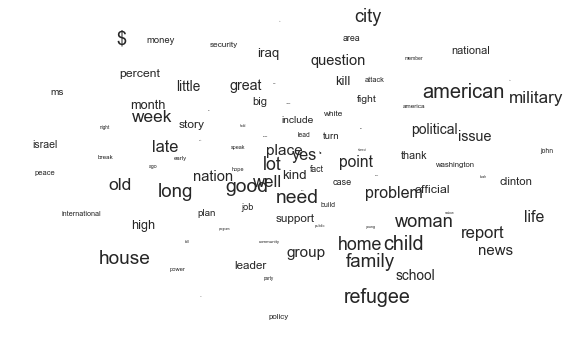

In [192]:
plot_embeddings(data_w2v, 100)

In [193]:
years=sorted(data['year'].unique())

1990
[('thousand', 0.9958568811416626), ('soldier', 0.9951590895652771), ('allow', 0.9950568675994873), ('presence', 0.9946506023406982), ('deployment', 0.9943908452987671), ('order', 0.9939771294593811), ('action', 0.9938927292823792), ('cross', 0.9937418699264526), ('ally', 0.9936684370040894), ('army', 0.9935412406921387)]


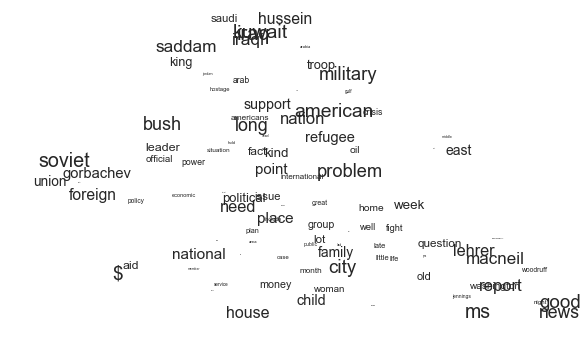

1991
[('border', 0.965378999710083), ('area', 0.9589267373085022), ('kurdish', 0.9577815532684326), ('camp', 0.9528588056564331), ('kurds', 0.9450044631958008), ('flee', 0.9445195198059082), ('troop', 0.9391324520111084), ('iran', 0.9383342862129211), ('qasr', 0.935625433921814), ('northern', 0.9335678219795227)]


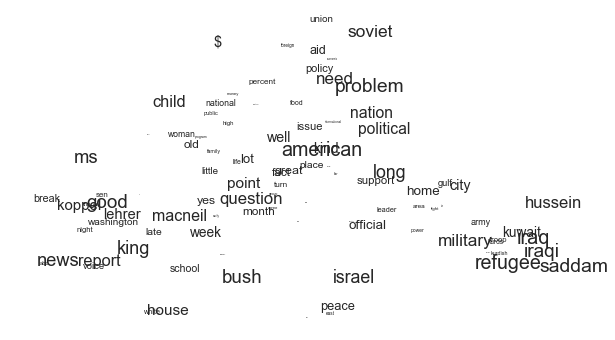

1992
[('nation', 0.998847484588623), ('food', 0.9985010623931885), ('area', 0.9984204173088074), ('relief', 0.9984084367752075), ('month', 0.9983659982681274), ('germany', 0.9982693791389465), ('worker', 0.9982154369354248), ('u.n', 0.9982091188430786), ('troop', 0.9981637001037598), ('political', 0.9981597661972046)]


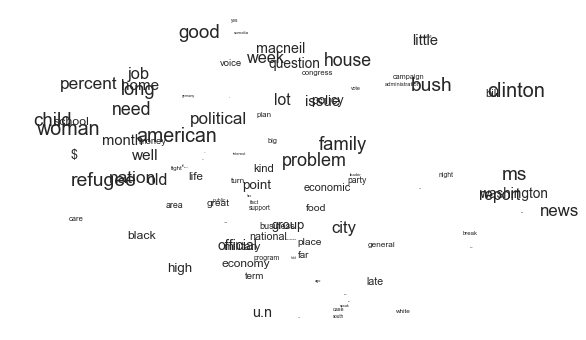

1993
[('nation', 0.9985637664794922), ('control', 0.9982977509498596), ('city', 0.9982418417930603), ('u.n', 0.9981346130371094), ('group', 0.9980026483535767), ('town', 0.9979985952377319), ('international', 0.9979457259178162), ('troop', 0.9977688789367676), ('srebrenica', 0.9977666139602661), ('ethnic', 0.9977543354034424)]


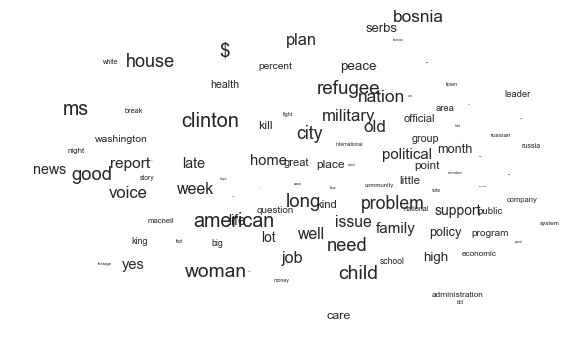

1994
[('military', 0.9644944071769714), ('haiti', 0.9582050442695618), ('nation', 0.956672191619873), ('troop', 0.9421786069869995), ('power', 0.9413032531738281), ('cuba', 0.9378640651702881), ('cuban', 0.935570478439331), ('korea', 0.9310136437416077), ('north', 0.928179144859314), ('air', 0.927659273147583)]


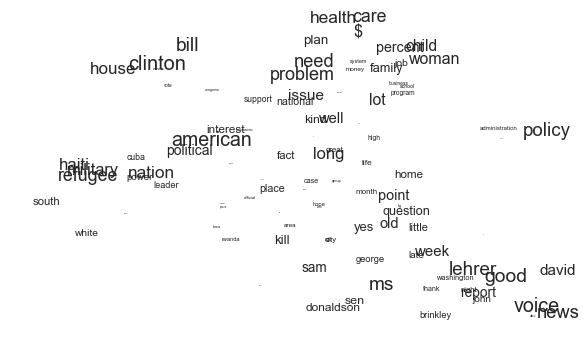

1995
[('area', 0.9997494220733643), ('fight', 0.9997125267982483), ('kill', 0.9996750950813293), ('control', 0.9996603727340698), ('camp', 0.99965900182724), ('arm', 0.9996460676193237), ('civilian', 0.9996386766433716), ('leader', 0.9996298551559448), ('flee', 0.9996265172958374), ('thousand', 0.9996210336685181)]


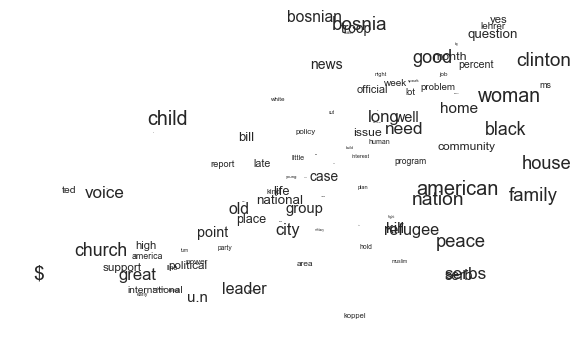

1996
[('camp', 0.9924960136413574), ('military', 0.9918550252914429), ('zaire', 0.9914100766181946), ('rwanda', 0.9905962347984314), ('home', 0.9895638227462769), ('hutu', 0.9894624352455139), ('troop', 0.9889382719993591), ('return', 0.9888870716094971), ('official', 0.988707959651947), ('international', 0.9880903959274292)]


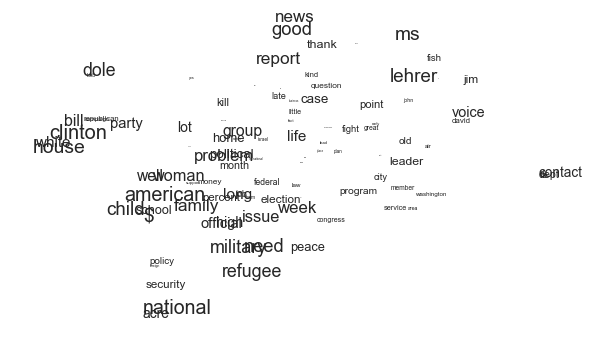

1997
[('worker', 0.9998725652694702), ('home', 0.9998589754104614), ('group', 0.9998570680618286), ('city', 0.9998501539230347), ('international', 0.999849796295166), ('agency', 0.9998477101325989), ('return', 0.9998455047607422), ('need', 0.9998454451560974), ('program', 0.9998406171798706), ('place', 0.9998400211334229)]


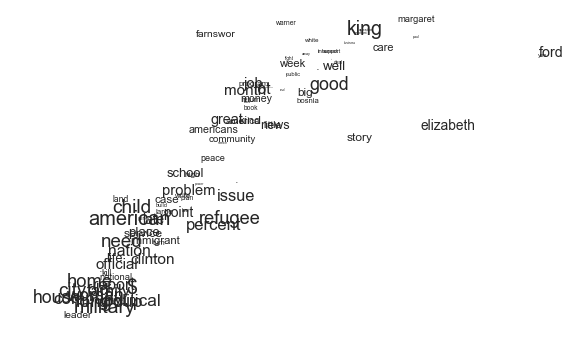

1998
[('center', 0.9999338388442993), ('head', 0.999932587146759), ('lead', 0.9999322891235352), ('place', 0.9999308586120605), ('face', 0.999930739402771), ('life', 0.9999297857284546), ('area', 0.9999294877052307), ('worker', 0.9999287128448486), ('international', 0.9999286532402039), ('month', 0.9999251961708069)]


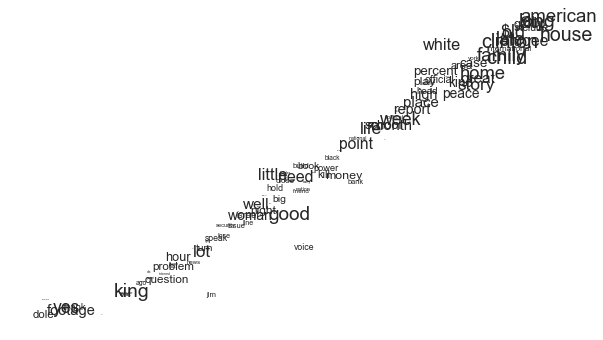

1999
[('serbs', 0.9979009032249451), ('albanians', 0.9967767596244812), ('serb', 0.9967539310455322), ('ethnic', 0.9964308142662048), ('serbian', 0.9962048530578613), ('albanian', 0.9960764050483704), ('kill', 0.9958571195602417), ('serbia', 0.9954656958580017), ('flee', 0.9951027631759644), ('yugoslav', 0.9949121475219727)]


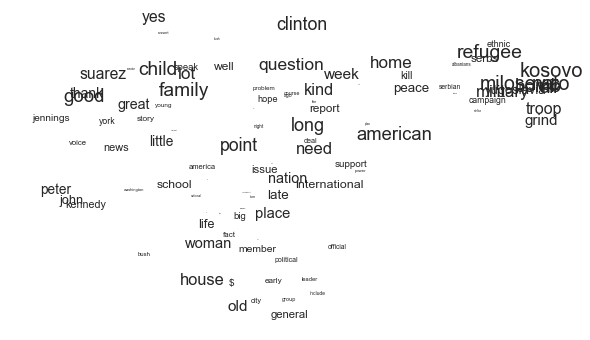

2000
[('david', 0.9994951486587524), ('jerusalem', 0.9993581771850586), ('palestinians', 0.9993557333946228), ('lebanon', 0.99935382604599), ('return', 0.9993113279342651), ('border', 0.9992852210998535), ('arab', 0.9992393255233765), ('west', 0.9992358684539795), ('leader', 0.9992040395736694), ('camp', 0.9992003440856934)]


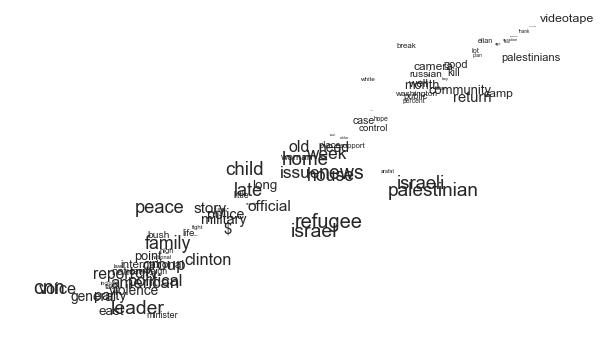

2001
[('border', 0.9993320107460022), ('near', 0.9992666840553284), ('flee', 0.9991943836212158), ('civilian', 0.9991680383682251), ('thousand', 0.9991071224212646), ('north', 0.9991044998168945), ('cross', 0.9990785121917725), ('afghans', 0.9990697503089905), ('pakistani', 0.9990686774253845), ('aid', 0.9990537166595459)]


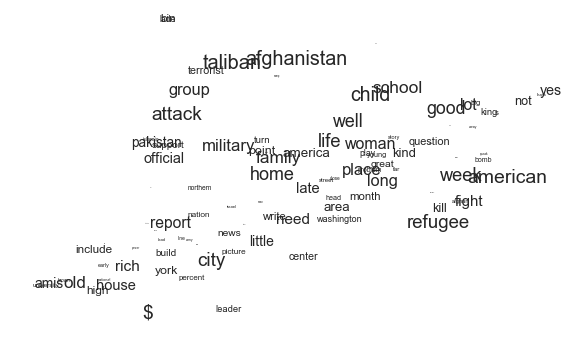

2002
[('jenin', 0.9944071173667908), ('camp', 0.9938624501228333), ('palestinians', 0.9884110689163208), ('israel', 0.9879082441329956), ('israeli', 0.9874767661094666), ('kill', 0.9874064922332764), ('ramallah', 0.9871389865875244), ('strip', 0.985228955745697), ('soldier', 0.9845753908157349), ('troop', 0.984370231628418)]


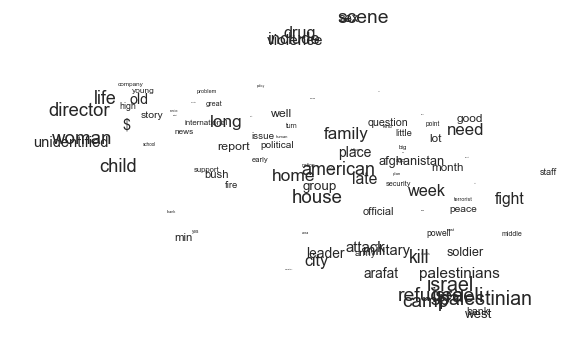

2003
[('home', 0.9997750520706177), ('official', 0.9997106790542603), ('nation', 0.9997074604034424), ('city', 0.9996813535690308), ('return', 0.999656617641449), ('international', 0.9996530413627625), ('troop', 0.9996508955955505), ('late', 0.9996412396430969), ('high', 0.9996116161346436), ('attack', 0.9996086359024048)]


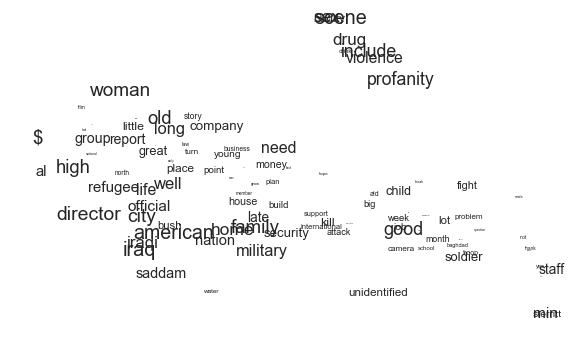

2004
[('attack', 0.9998866319656372), ('group', 0.9998770952224731), ('place', 0.9998718500137329), ('life', 0.9998692274093628), ('south', 0.9998682141304016), ('home', 0.9998680353164673), ('troop', 0.9998637437820435), ('week', 0.9998631477355957), ('city', 0.9998586177825928), ('family', 0.9998549222946167)]


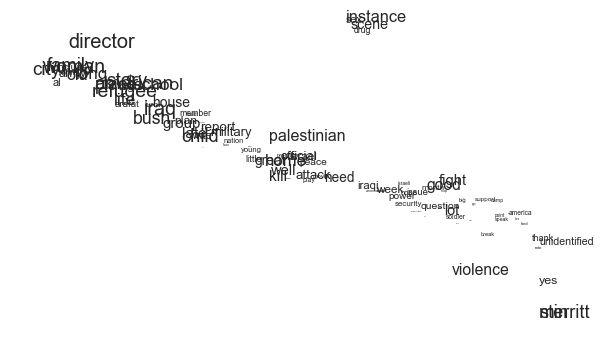

2005
[('place', 0.9998281598091125), ('problem', 0.999812126159668), ('set', 0.9998060464859009), ('worker', 0.9998006820678711), ('victim', 0.9997920989990234), ('response', 0.9997777342796326), ('head', 0.9997762441635132), ('hit', 0.9997758865356445), ('small', 0.9997749924659729), ('group', 0.9997724890708923)]


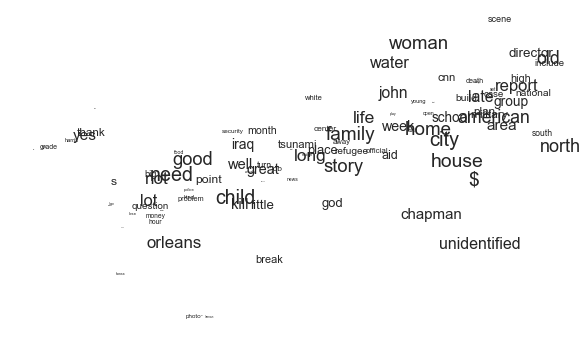

2006
[('america', 0.999618649482727), ('close', 0.9996170997619629), ('flee', 0.999616265296936), ('neighbor', 0.9996117949485779), ('return', 0.9995999932289124), ('far', 0.9995956420898438), ('send', 0.9995915293693542), ('town', 0.9995914101600647), ('trip', 0.9995757341384888), ('grow', 0.9995630979537964)]


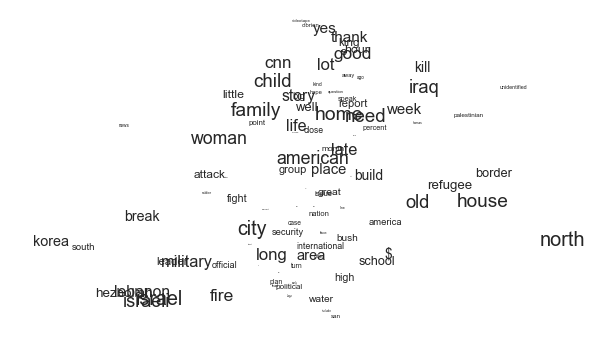

2007
[('border', 0.999800443649292), ('palestinian', 0.9997864365577698), ('iraqi', 0.9997847676277161), ('flee', 0.999773383140564), ('iraqis', 0.9997718334197998), ('lebanon', 0.9997701644897461), ('arab', 0.9997698068618774), ('area', 0.9997680187225342), ('city', 0.9997677803039551), ('international', 0.9997636079788208)]


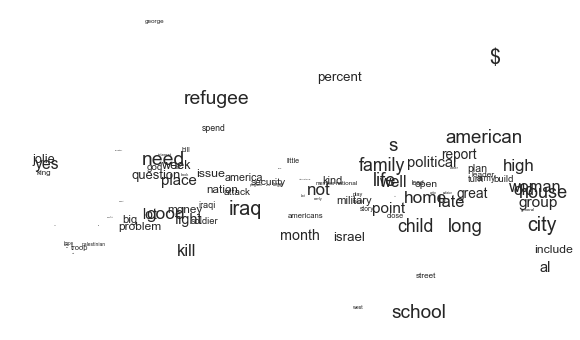

2008
[('lead', 0.9999525547027588), ('life', 0.9999513030052185), ('american', 0.9999510645866394), ('home', 0.9999505877494812), ('political', 0.9999476075172424), ('need', 0.999947190284729), ('iraq', 0.9999468326568604), ('write', 0.9999457001686096), ('city', 0.9999455213546753), ('week', 0.9999445676803589)]


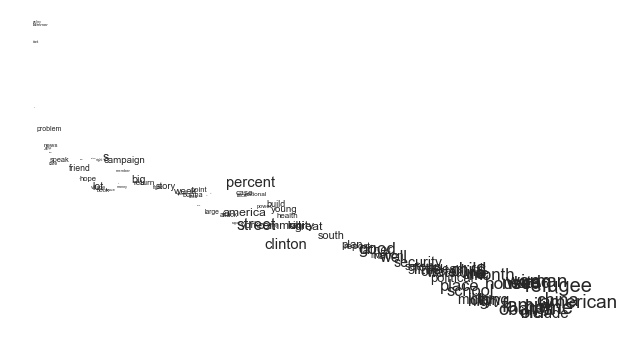

2009
[('american', 0.9999477863311768), ('lead', 0.9999473690986633), ('city', 0.9999454021453857), ('old', 0.9999436140060425), ('life', 0.9999434351921082), ('home', 0.9999427795410156), ('center', 0.9999425411224365), ('place', 0.9999415874481201), ('group', 0.9999415874481201), ('include', 0.9999414682388306)]


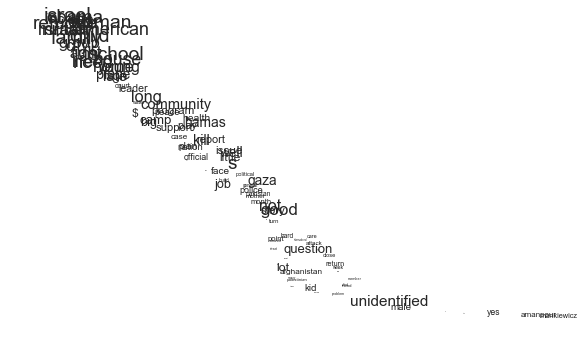

2010
[('lead', 0.9999535083770752), ('city', 0.9999485015869141), ('week', 0.9999475479125977), ('set', 0.9999463558197021), ('american', 0.9999459981918335), ('place', 0.9999443292617798), ('group', 0.9999438524246216), ('life', 0.999943733215332), ('home', 0.99994295835495), ('head', 0.9999426603317261)]


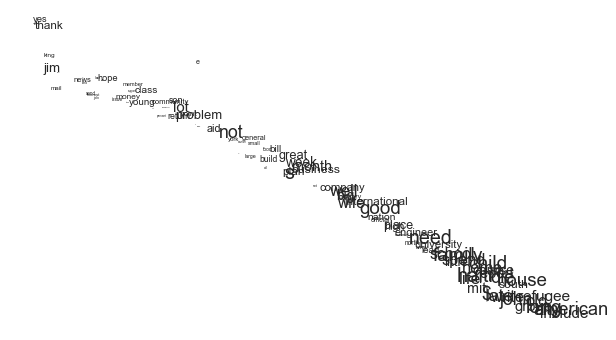

2011
[('border', 0.9999147653579712), ('city', 0.9999016523361206), ('home', 0.9999000430107117), ('area', 0.9998999238014221), ('lead', 0.9998944997787476), ('near', 0.9998924732208252), ('town', 0.999890148639679), ('place', 0.9998891949653625), ('arm', 0.9998887777328491), ('troop', 0.9998871088027954)]


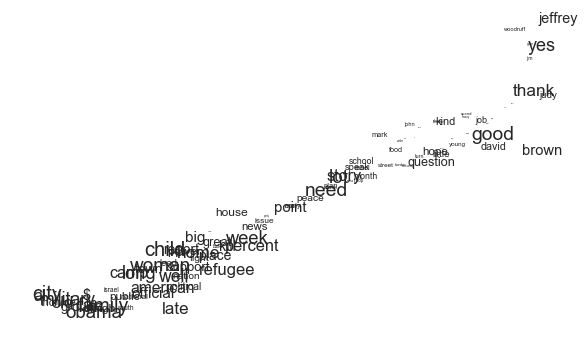

2012
[('turkey', 0.999653160572052), ('control', 0.9996227025985718), ('support', 0.9996060729026794), ('border', 0.9995803236961365), ('camp', 0.9995698928833008), ('group', 0.9995620250701904), ('flee', 0.999524712562561), ('military', 0.9994984865188599), ('turkish', 0.999487042427063), ('include', 0.9994784593582153)]


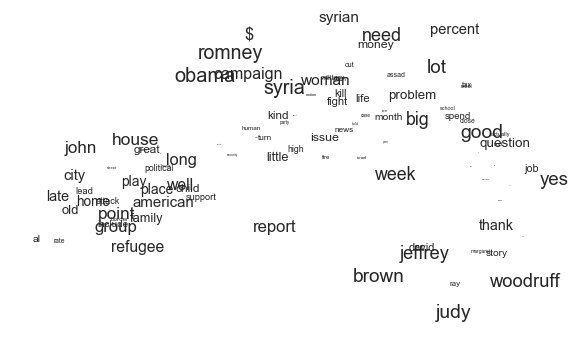

2013
[('border', 0.9996665716171265), ('conflict', 0.9996181726455688), ('numb', 0.9995702505111694), ('inside', 0.9995636940002441), ('population', 0.9995401501655579), ('jordan', 0.9995284080505371), ('power', 0.9995265007019043), ('international', 0.9995200634002686), ('council', 0.9995161294937134), ('civil', 0.9995129108428955)]


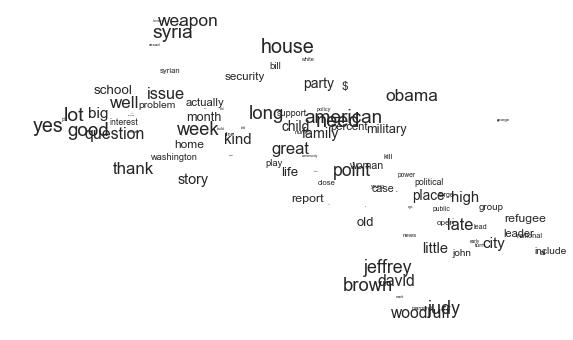

2014
[('flee', 0.9974199533462524), ('thousand', 0.9971452951431274), ('camp', 0.9969527125358582), ('area', 0.9968210458755493), ('cross', 0.9967553615570068), ('kill', 0.9967470169067383), ('large', 0.9964568614959717), ('lebanon', 0.9964287281036377), ('syrian', 0.9963135123252869), ('city', 0.9962670803070068)]


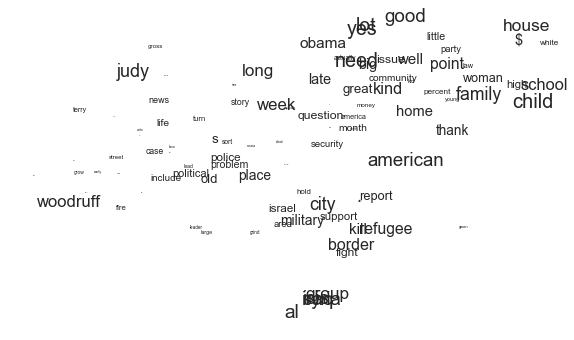

2015
[('europe', 0.9875989556312561), ('syria', 0.9848854541778564), ('syrian', 0.9793765544891357), ('crisis', 0.9761264324188232), ('migrant', 0.9753063321113586), ('iraq', 0.9718925952911377), ('isis', 0.9681304693222046), ('al', 0.9660816192626953), ('border', 0.9653311967849731), ('group', 0.9614424705505371)]


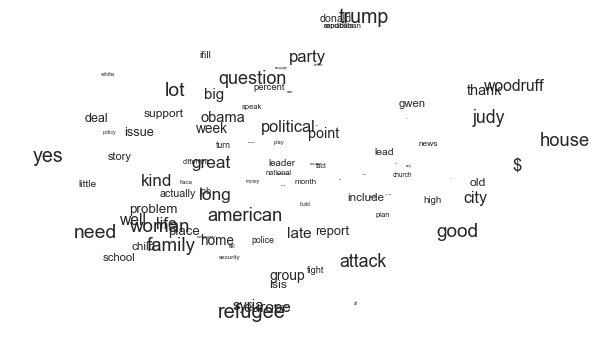

In [194]:
# Year on year
yearly_w2v = {}
for yr in years:
    yearly = data[data['year']==yr]
    data_w2v = gensim.models.word2vec.Word2Vec(yearly['normalized_sents'].sum())
    yearly_w2v[yr] = data_w2v
    print(yr)
    print(data_w2v.most_similar(positive=['refugee']))
    plot_embeddings(data_w2v, 100, save=True, title='{}.png'.format(yr))

In [195]:
yearly_w2v

{1990: <gensim.models.word2vec.Word2Vec at 0x1922af340>,
 1991: <gensim.models.word2vec.Word2Vec at 0x18a147760>,
 1992: <gensim.models.word2vec.Word2Vec at 0x1821e40d0>,
 1993: <gensim.models.word2vec.Word2Vec at 0x18260af40>,
 1994: <gensim.models.word2vec.Word2Vec at 0x1fb764dc0>,
 1995: <gensim.models.word2vec.Word2Vec at 0x1922af430>,
 1996: <gensim.models.word2vec.Word2Vec at 0x18c504400>,
 1997: <gensim.models.word2vec.Word2Vec at 0x1fcdaf790>,
 1998: <gensim.models.word2vec.Word2Vec at 0x184dd59a0>,
 1999: <gensim.models.word2vec.Word2Vec at 0x187950d00>,
 2000: <gensim.models.word2vec.Word2Vec at 0x1fca6cca0>,
 2001: <gensim.models.word2vec.Word2Vec at 0x1fca6c9a0>,
 2002: <gensim.models.word2vec.Word2Vec at 0x28b05a580>,
 2003: <gensim.models.word2vec.Word2Vec at 0x182523100>,
 2004: <gensim.models.word2vec.Word2Vec at 0x1942da790>,
 2005: <gensim.models.word2vec.Word2Vec at 0x2895e0700>,
 2006: <gensim.models.word2vec.Word2Vec at 0x1943f1130>,
 2007: <gensim.models.word2vec.

In [263]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def makeDF(model, word_list, Dim1, Dim2, dim1_label, dim2_label):
    dim1 = []
    dim2 = []
    for word in word_list:
        dim1.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim1.reshape(1,-1))[0][0])
        dim2.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim2.reshape(1,-1))[0][0])
    df = pd.DataFrame({dim1_label: dim1, dim2_label: dim2}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [295]:
def get_common_words():
    words = {}
    common = []

    for yr in years:
        vocab = list(yearly_w2v[yr].wv.vocab.keys())
        for v in vocab:
            if v in words:
                words[v] += 1
            else:
                words[v] = 1
    for w, count in words.items():
        if count >= len(years):
            common.append(w)
    return common

In [298]:
common = get_common_words()
len(common)

1759

In [381]:
countries_w2v = []
for country in countrylist:
    if country in common:
        countries_w2v.append(country.lower())

In [382]:
countries_w2v

['afghanistan',
 'china',
 'egypt',
 'france',
 'georgia',
 'germany',
 'india',
 'iran',
 'iraq',
 'israel',
 'jersey',
 'jordan',
 'lebanon',
 'pakistan',
 'russia',
 'turkey',
 'vietnam']

<ipython-input-373-8cc9767f6c2e>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (12,4))
<ipython-input-373-8cc9767f6c2e>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (12,4))
<ipython-input-373-8cc9767f6c2e>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt

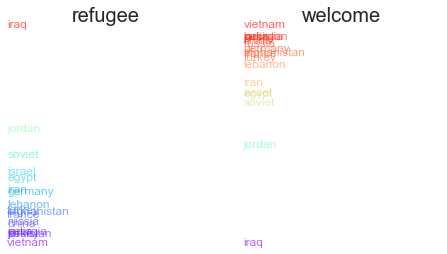

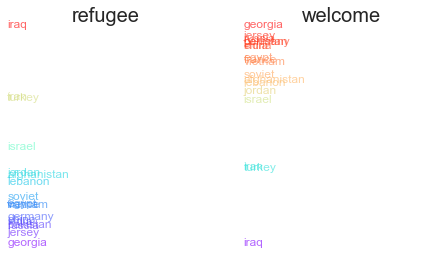

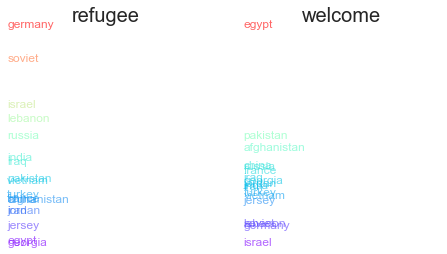

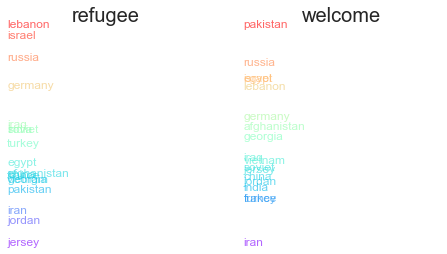

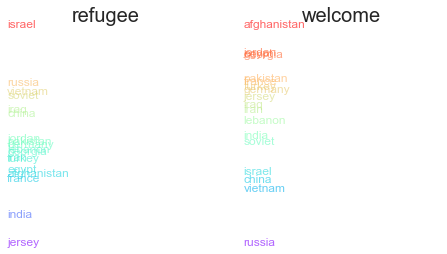

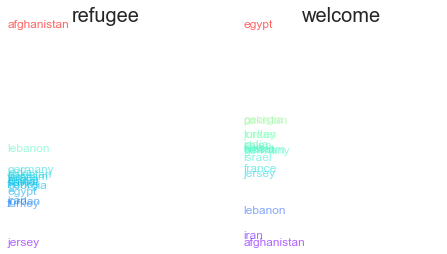

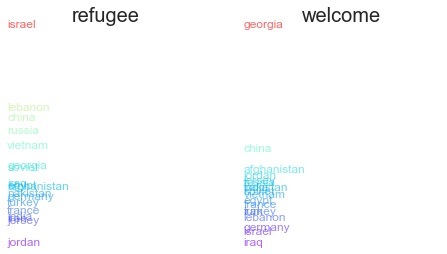

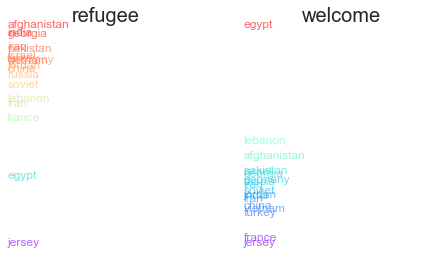

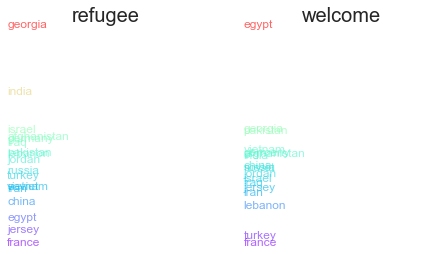

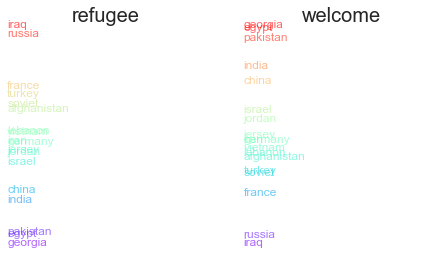

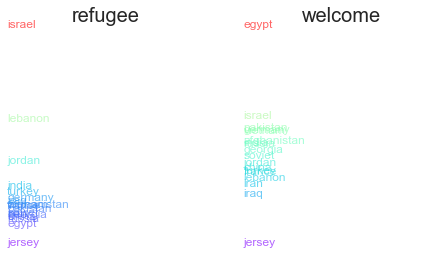

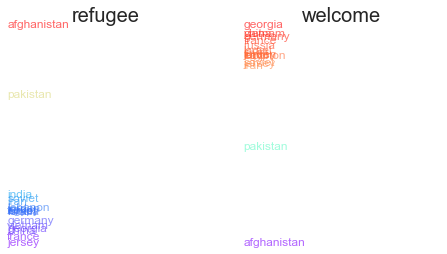

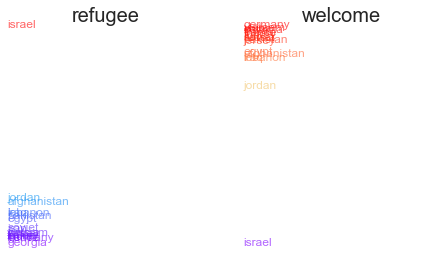

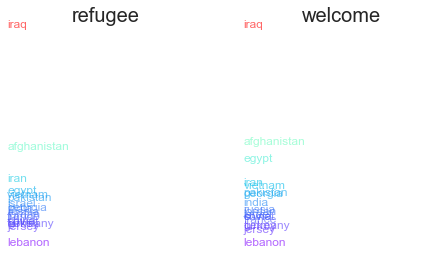

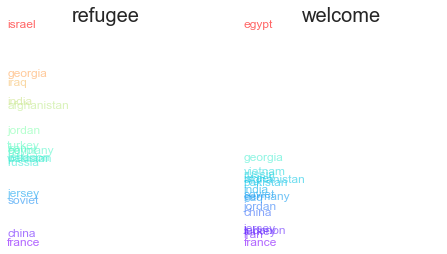

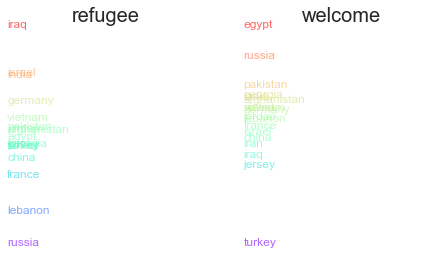

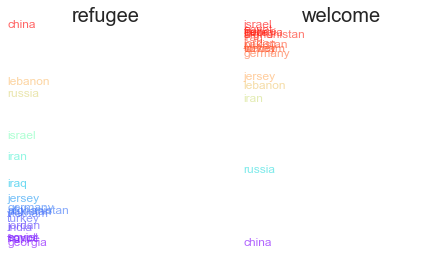

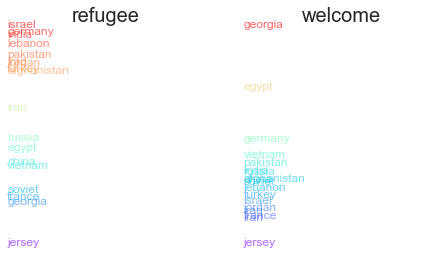

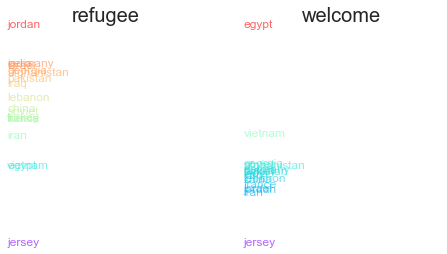

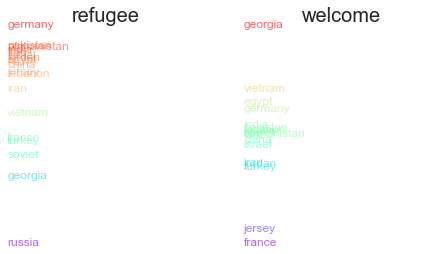

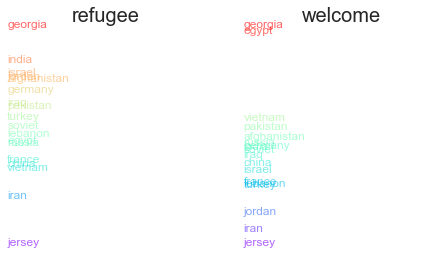

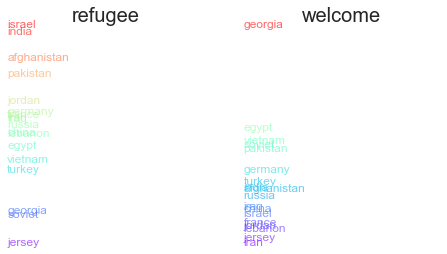

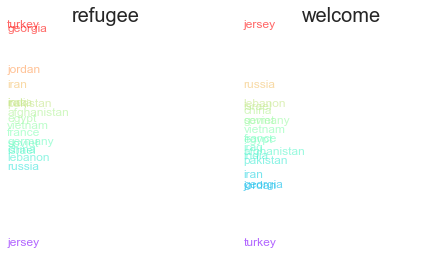

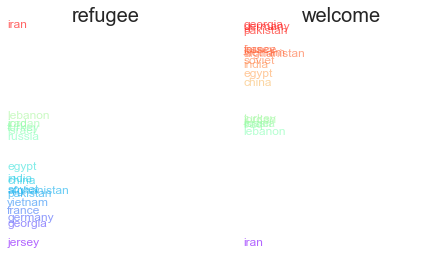

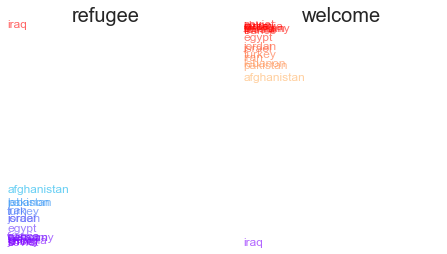

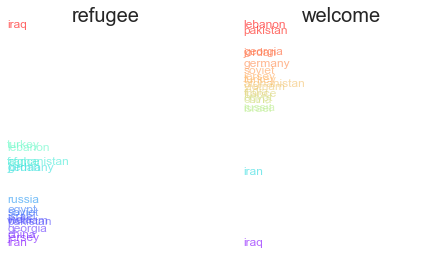

In [373]:
for yr in years:
    model = yearly_w2v[yr]
    Refugee = dimension(model, ['refugee','displace'], ['native','worker'])
    Welcome = dimension(model, ['welcome', 'accept'], ['ban','flee'])
    countries_full = countries_w2v + ['soviet']
    df = makeDF(model, countries_full, Refugee, Welcome, 'refugee', 'welcome') 
    fig = plt.figure(figsize = (12,4))
    ax1 = fig.add_subplot(131)
    PlotDimension(ax1, df, 'refugee')
    ax2 = fig.add_subplot(132)
    PlotDimension(ax2, df, 'welcome')
    plt.show

### doc2vec

In [196]:
# def tag_docs(data):
#     taggedDocs = []
#     for index, row in data.iterrows():
#         #Just doing a simple keyword assignment
#         docKeywords = [row['year']]
#         docKeywords.append(row['text_id'])
#         docKeywords.append(row['genre'])
#         docKeywords.append(row['word_count'])
#         taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
#     return taggedDocs

# data['tagged_docs'] = tag_docs(data)

In [197]:
# memory error
#data_d2v = gensim.models.doc2vec.Doc2Vec(data['tagged_docs'],vector_size=100)

In [198]:
# data_d2v.save("data_d2v")

In [199]:
# data_d2v.most_similar(positive = ['immigrants','illegal'], negative = ['legal'], topn = 10)

In [200]:
# def most_similar_by_year(data_d2v,years):
#     for yr in years:
#         print(yr)
#         print(data_d2v.most_similar( [ data_d2v.docvecs[yr] ], topn=5))
#         print()

# years = range(1990,2016)        
# most_similar_by_year(data_d2v, years)

In [201]:
# genre = list(data['genre'].unique())       
# most_similar_by_year(data_d2v, genre)

In [202]:
# def plot_similarity(data_d2v, targetDocs):
#     heatmapMatrixD = []
#     for tagOuter in targetDocs:
#         column = []
#         tagVec = data_d2v.docvecs[tagOuter].reshape(1, -1)
#         for tagInner in targetDocs:
#             column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, data_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
#         heatmapMatrixD.append(column)
#     heatmapMatrixD = np.array(heatmapMatrixD)
#     fig, ax = plt.subplots()
#     hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
#     cbar = plt.colorbar(hmap)

#     cbar.set_label('cosine similarity', rotation=270)
#     a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
#     a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

#     a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
#     a = ax.set_yticklabels(targetDocs, minor=False)

In [203]:
# plot_similarity(data_d2v, list(data['year'].unique()))

In [204]:
# plot_similarity(data_d2v, list(data['genre'].unique()))

### change over time

In [205]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [206]:
data_rawEmbeddings, data_comparedEmbeddings = compareModels(data, 'year')

In [207]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

def plot_divergence(targetWord, comparedEmbeddings):
    pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
    fig, ax = plt.subplots(figsize = (10, 7))
    sns.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
    ax.set_xlabel("Starting year")
    ax.set_ylabel("Final year")
    ax.set_ylabel("Final year")
    ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
    plt.show()

In [208]:
def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

data_wordDivergences = findMostDivergent(data_comparedEmbeddings)

Found 1759 words to compare


In [209]:
# most divergence
data_wordDivergences[:20]

[('hussein', 13.763208895921707),
 ('soviet', 11.493855655193329),
 ('union', 10.617297917604446),
 ('ms', 10.438908159732819),
 ('$', 9.070065915584564),
 ('news', 8.875071823596954),
 ('house', 7.7027997970581055),
 ('middle', 7.211271435022354),
 ('iraq', 6.81386211514473),
 ('east', 6.260174512863159),
 ('white', 6.066702902317047),
 ('king', 5.604938387870789),
 ('good', 4.542757034301758),
 ('troop', 4.448693811893463),
 ('foreign', 4.263371169567108),
 ('military', 3.1310287714004517),
 ('black', 2.936962604522705),
 ('photo', 2.869722068309784),
 ('minister', 2.625311493873596),
 ('night', 2.6226035356521606)]

In [210]:
# least divergence
data_wordDivergences[-20:]

[('eventually', 0.01509171724319458),
 ('wide', 0.015023767948150635),
 ('similar', 0.014883160591125488),
 ('rest', 0.014568328857421875),
 ('complete', 0.014518499374389648),
 ('lack', 0.014340221881866455),
 ('activity', 0.01391524076461792),
 ('traditional', 0.013865113258361816),
 ('largely', 0.013500511646270752),
 ('develope', 0.013433277606964111),
 ('document', 0.013400852680206299),
 ('nature', 0.01289379596710205),
 ('body', 0.012579917907714844),
 ('dead', 0.012476801872253418),
 ('prove', 0.01240009069442749),
 ('subject', 0.012361109256744385),
 ('religious', 0.012279033660888672),
 ('fill', 0.011375904083251953),
 ('travel', 0.010366320610046387),
 ('describe', 0.009694993495941162)]

refugee


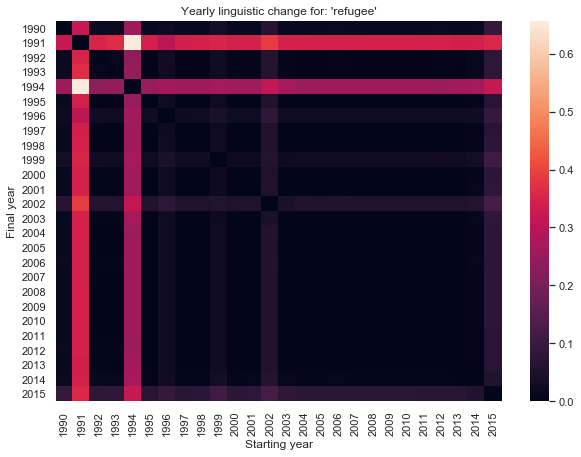

In [211]:
plot_divergence('refugee', data_comparedEmbeddings)

soviet


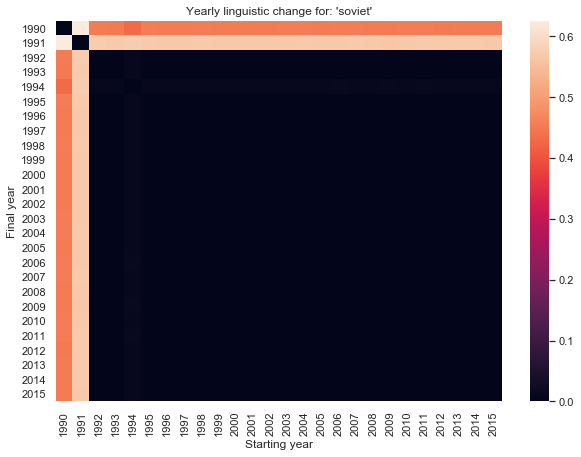

In [212]:
plot_divergence('soviet', data_comparedEmbeddings)

union


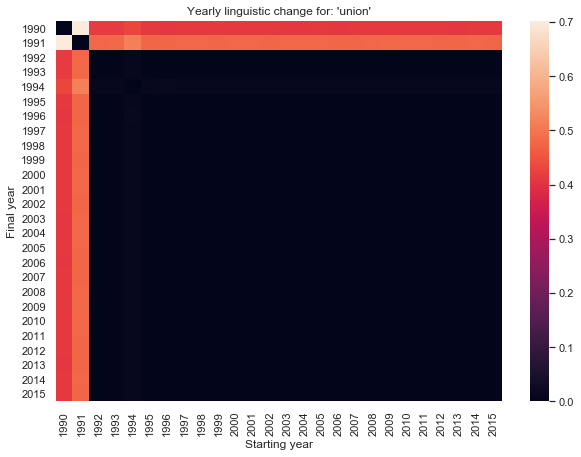

In [213]:
plot_divergence('union', data_comparedEmbeddings)

$


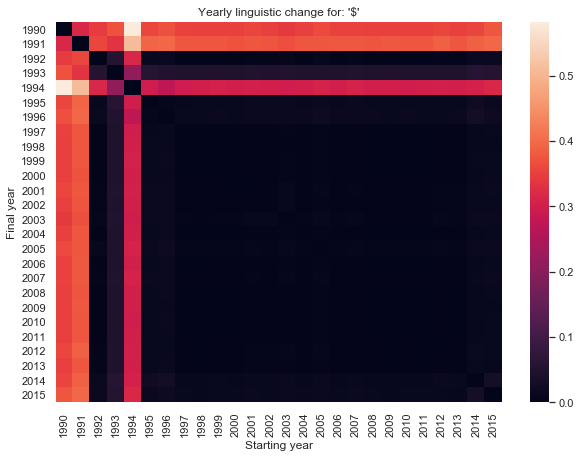

In [214]:
plot_divergence('$', data_comparedEmbeddings)

iraq


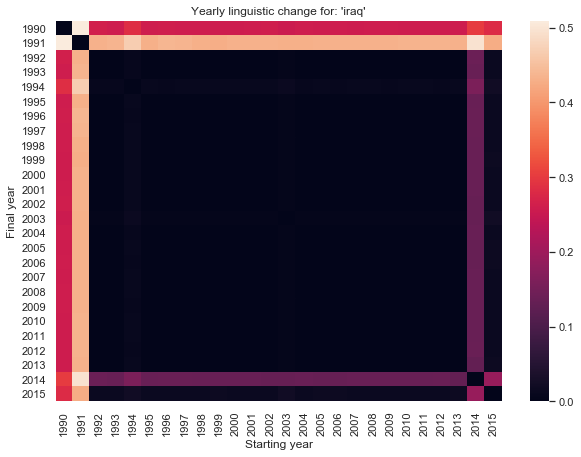

In [215]:
plot_divergence('iraq', data_comparedEmbeddings)

middle


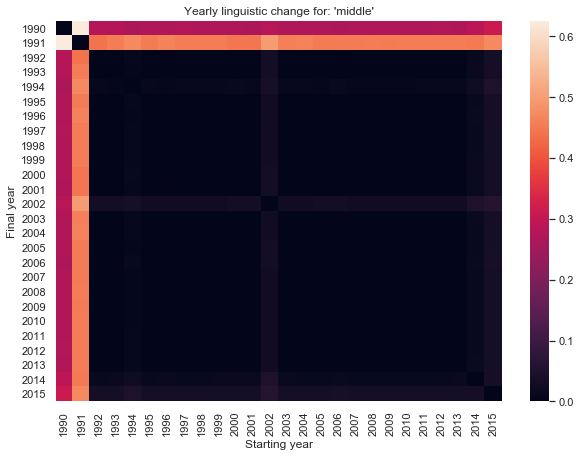

In [216]:
plot_divergence('middle', data_comparedEmbeddings)

east


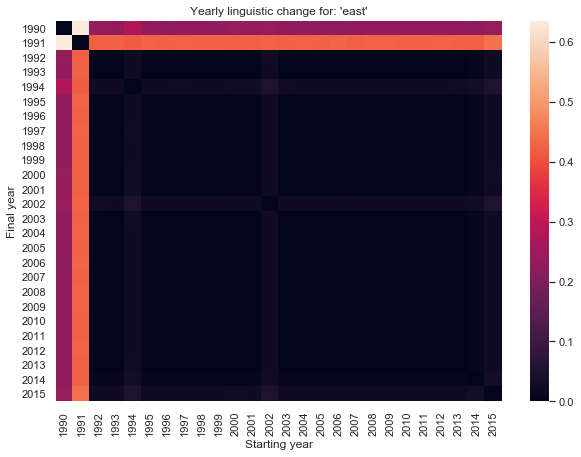

In [217]:
plot_divergence('east', data_comparedEmbeddings)

troop


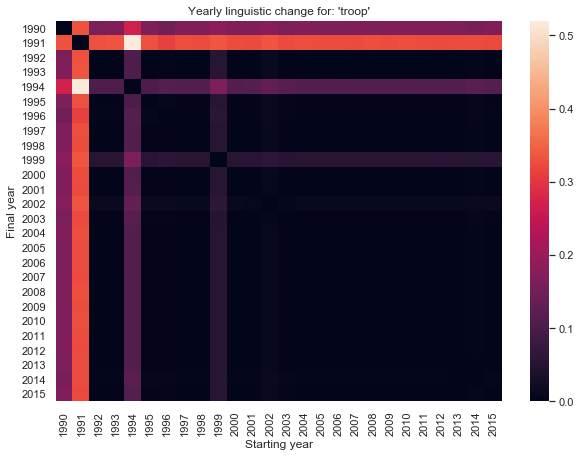

In [219]:
plot_divergence('troop', data_comparedEmbeddings)

military


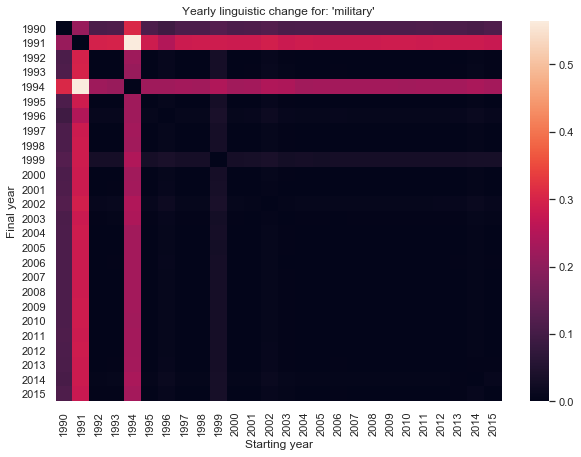

In [220]:
plot_divergence('military', data_comparedEmbeddings)

hussein


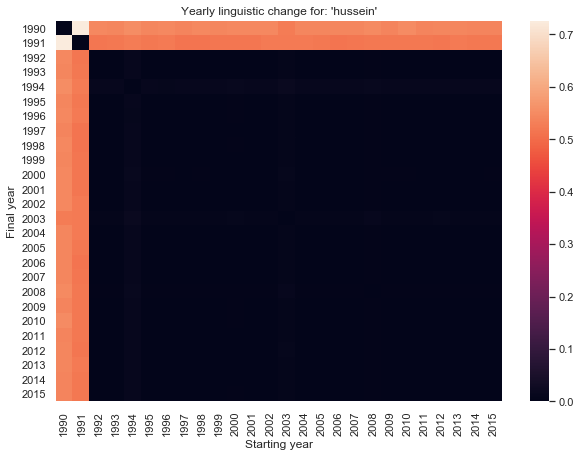

In [221]:
plot_divergence('hussein', data_comparedEmbeddings)

good


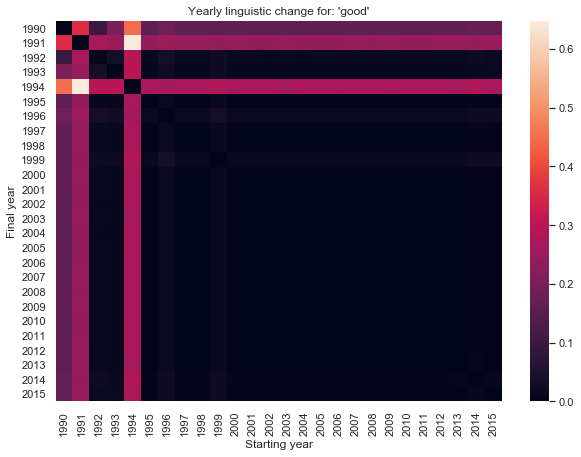

In [222]:
plot_divergence('good', data_comparedEmbeddings)